In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   cuneo
   2   savona
   3   ancona
   4   potenza
   5   catania
   6   modena
   7   trapani
   8   lecce
   9   forli
   10   imperia
   11   mantova
   12   catanzaro
   13   venezia
   14   grosseto
   15   rimini
   16   lecco
   17   caltanissetta
   18   sassari
   19   nuoro
   20   ferrara
   21   bologna
   22   latina
   23   ravenna
   24   palermo
   25   viterbo
   26   parma
   27   trento
   28   matera
   29   novara
   30   cagliari
   31   belluno
   32   chieti
   33   treviso
   34   bat
   35   reggio_nell_emilia
   36   varese
   37   perugia
   38   bolzano
   39   teramo
   40   udine
   41   sondrio
   42   salerno
   43   messina
   44   siena
   45   avellino
   46   taranto
   47   milano
   48   isernia
   49   brescia
   50   pescara
   51   reggio_di_calabria
   52   monza
   53   pisa
   54   vibo_valentia
   55   ascoli_piceno
   56   cremona
   57   foggia
   58   rieti
  

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 cuneo
2 savona
3 ancona
4 potenza
5 catania
6 modena
7 trapani
8 lecce
9 forli
10 imperia
11 mantova
12 catanzaro
13 venezia
14 grosseto
15 rimini
16 lecco
17 caltanissetta
18 sassari
19 nuoro
20 ferrara
21 bologna
22 latina
23 ravenna
24 palermo
25 viterbo
26 parma
27 trento
28 matera
29 novara
30 cagliari
31 belluno
32 chieti
33 treviso
34 bat
35 reggio_nell_emilia
36 varese
37 perugia
38 bolzano
39 teramo
40 udine
41 sondrio
42 salerno
43 messina
44 siena
45 avellino
46 taranto
47 milano
48 brescia
49 pescara
50 reggio_di_calabria
51 monza
52 pisa
53 vibo_valentia
54 ascoli_piceno
55 cremona
56 foggia
57 rieti
58 bergamo
59 vercelli
60 gorizia
61 padova
62 l_aquila
63 cosenza
64 asti
65 roma
66 enna
67 prato
68 siracusa
69 massa
70 brindisi
71 rovigo
72 firenze
73 crotone
74 biella
75 campobasso
76 lodi
77 lucca
78 alessandria
79 livorno
80 pavia
81 caserta
82 fermo
83 verona
84 torino
85 pordenone
86 bari
87 pistoia
88 napoli
89 genova
90 como
91 arezzo
92 piacenza
93 frosinone
9

In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

In [6]:
feats_innet_to_visualnamemap = {"density" : "Density",
                                "commutersdensity" : "Com. Density",                          
                                "depriv" : "Depriv. Index",
                                "lat" : "Latitude",
                                "Ratio0200ver65" : "Old Young Ratio",
                                "avg_wpm10_period1_2020" : "Avg. PM10",
                                "avg_wno_period1_2020" : "Avg. NO",
                                "avg_wpans_period1_2020" : "Avg. PANS",
                                "avg_wso2_period1_2020" : "Avg. SO2",
                                "randomfeature" : "Random Feat."}

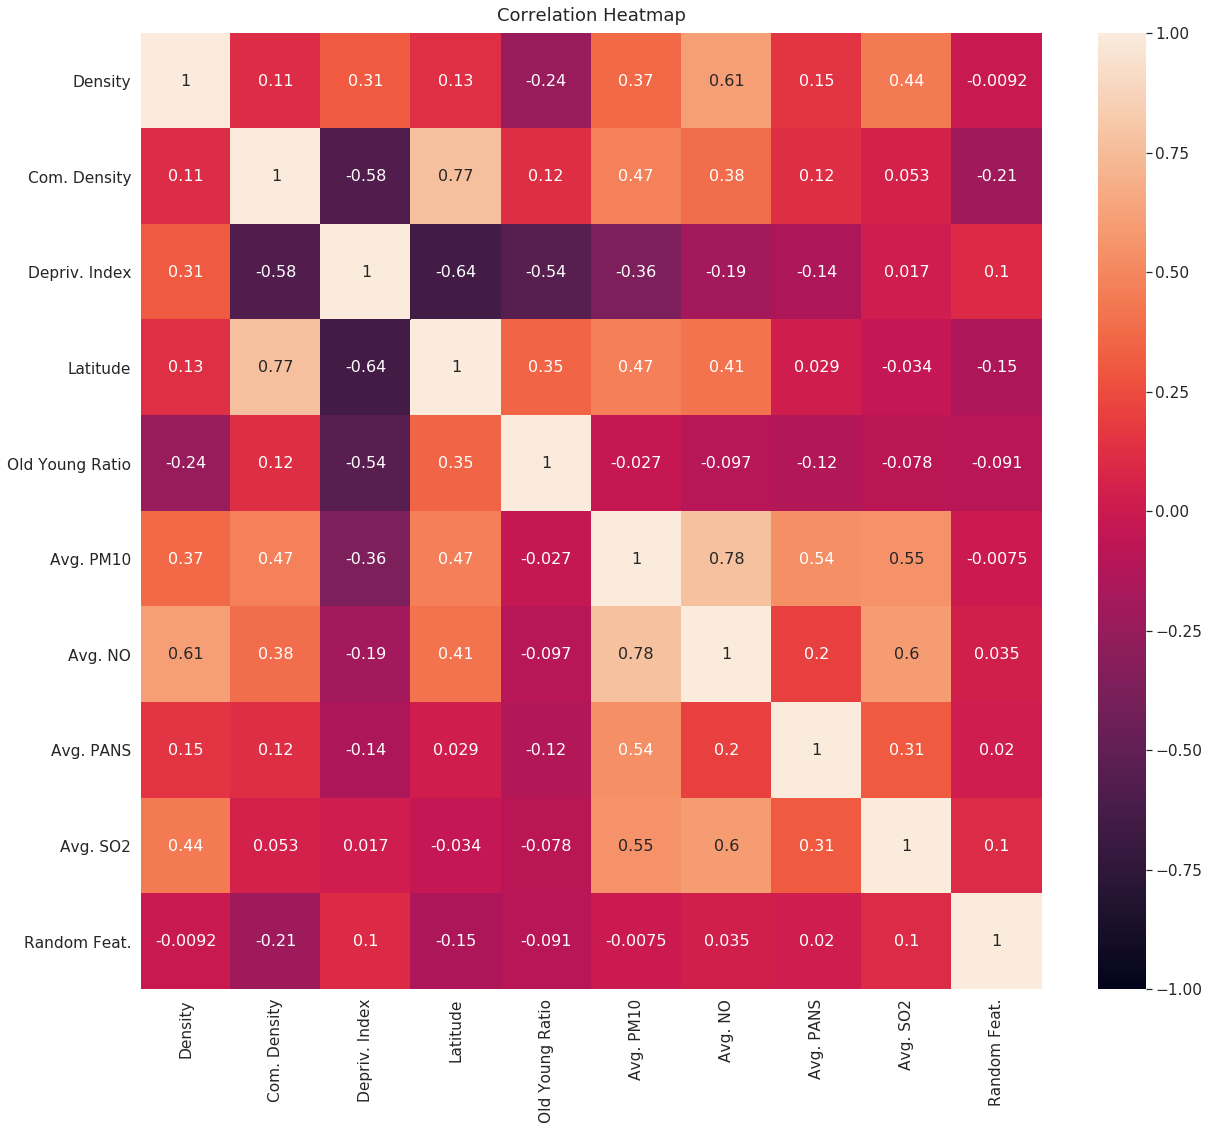

In [7]:
import seaborn as sns

featuresused = features

evaluatecorrelation = {}

for v in featuresused:
    vname = feats_innet_to_visualnamemap[v]
    evaluatecorrelation[vname] = features_dict[v]

plt.figure(figsize=(18, 16))
features_df = pd.DataFrame.from_dict(evaluatecorrelation)

sns.set(font_scale=1.4)
heatmap = sns.heatmap(features_df.corr(),vmin=-1, vmax=1, annot=True , annot_kws={"size": 16});
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

figure = heatmap.get_figure()    
figure.subplots_adjust()
figure.tight_layout()
figure.savefig('heatmap.png',  bbox_inches="tight", pad_inches=0.5)


Grid Search to optimize the RMSE on the Full Set

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.35053  0.02149 
    Test set average RMSE:  0.94283  0.10343 

Prediction STD :    1.28548
True value STD :    1.47826
Difference in percentage:   13.04072

             Fullset RMSE:    0.33954
                       R2:    0.94724


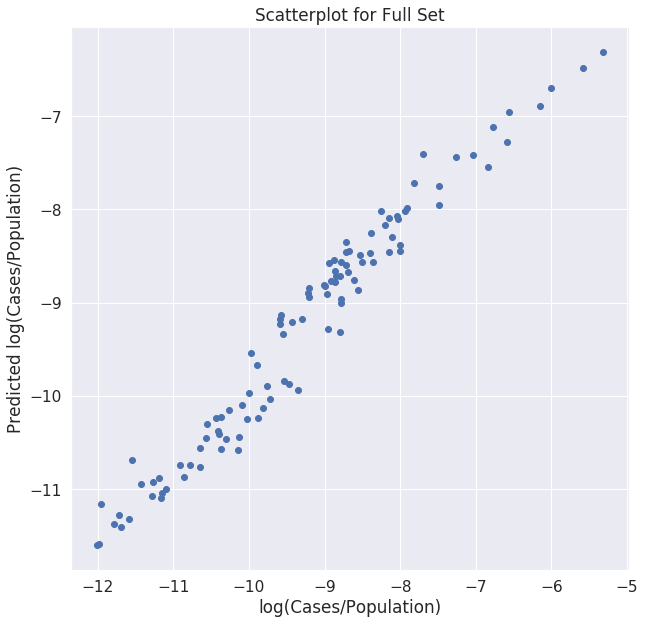

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.06056 +/- 0.00553
Feature:                   Com. Density, Score: 0.27252 +/- 0.04276
Feature:                  Depriv. Index, Score: 0.11770 +/- 0.01211
Feature:                       Latitude, Score: 0.85297 +/- 0.10545
Feature:                Old Young Ratio, Score: 0.12242 +/- 0.01852
Feature:                      Avg. PM10, Score: 0.20296 +/- 0.02929
Feature:                        Avg. NO, Score: 0.21430 +/- 0.02953
Feature:                      Avg. PANS, Score: 0.06089 +/- 0.00752
Feature:                       Avg. SO2, Score: 0.08492 +/- 0.00896


<Figure size 432x288 with 0 Axes>

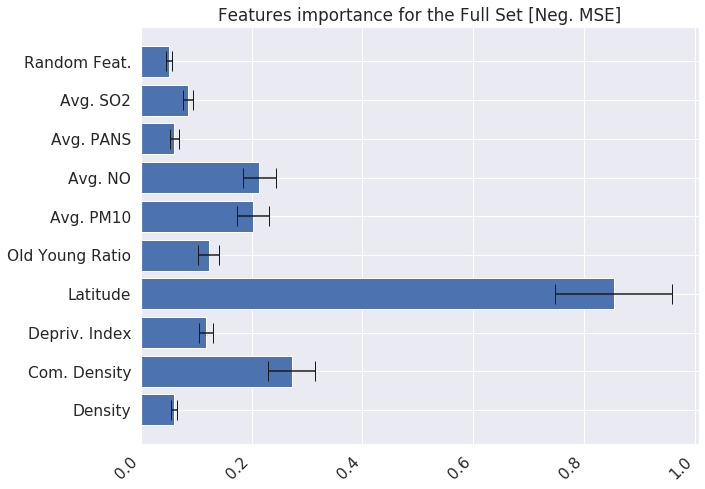

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.02771 +/- 0.00253
Feature:                   Com. Density, Score: 0.12471 +/- 0.01957
Feature:                  Depriv. Index, Score: 0.05386 +/- 0.00554
Feature:                       Latitude, Score: 0.39033 +/- 0.04825
Feature:                Old Young Ratio, Score: 0.05602 +/- 0.00848
Feature:                      Avg. PM10, Score: 0.09288 +/- 0.01341
Feature:                        Avg. NO, Score: 0.09807 +/- 0.01351
Feature:                      Avg. PANS, Score: 0.02787 +/- 0.00344
Feature:                       Avg. SO2, Score: 0.03886 +/- 0.00410


<Figure size 432x288 with 0 Axes>

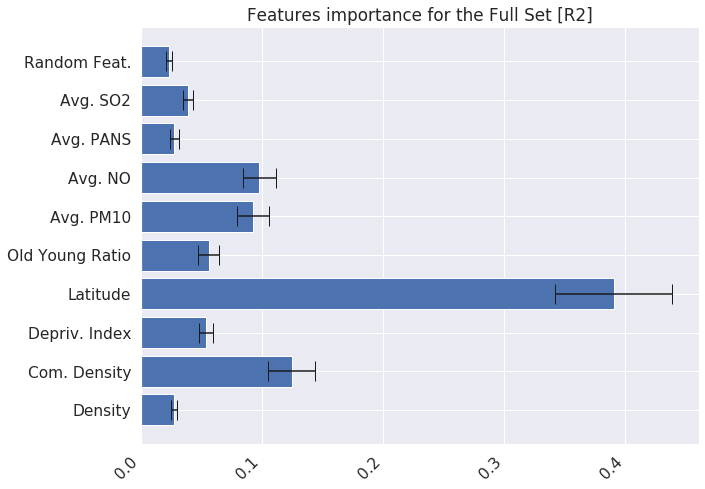

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.33545
                       R2:    0.94603


<Figure size 432x288 with 0 Axes>

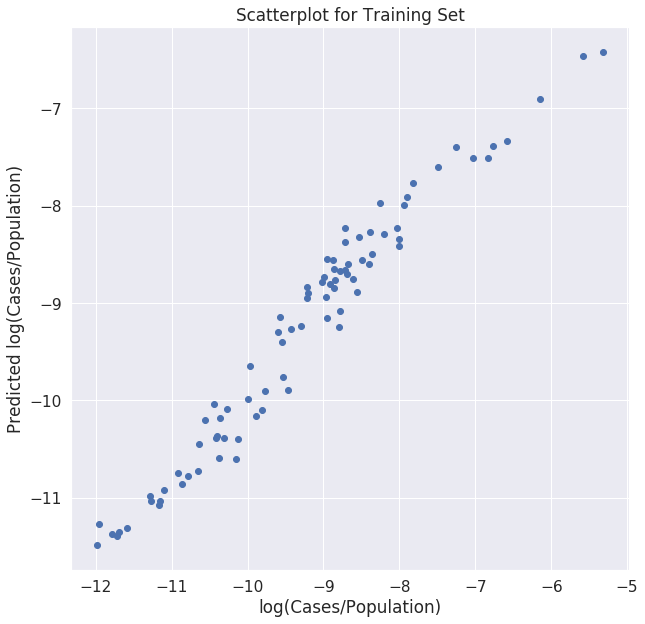

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.04950
                       R2:    0.57271


<Figure size 432x288 with 0 Axes>

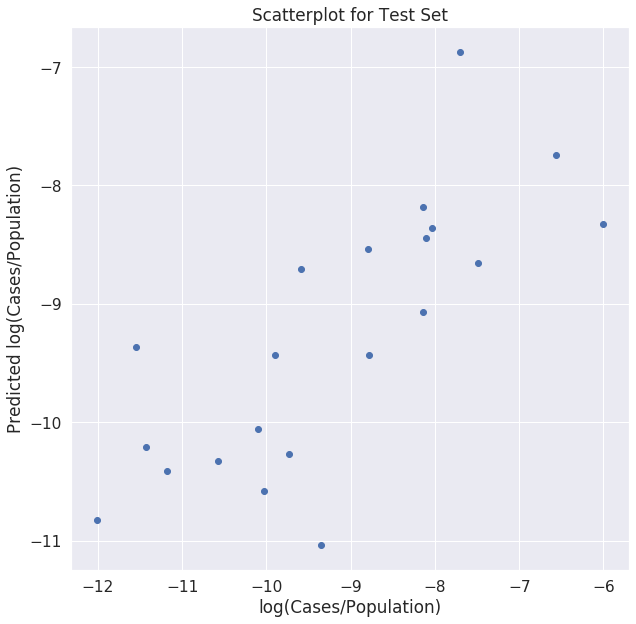

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.21934 +/- 0.14002
Feature:                  Depriv. Index, Score: 0.05842 +/- 0.04955
Feature:                       Latitude, Score: 0.78942 +/- 0.32190
Feature:                      Avg. PM10, Score: 0.10367 +/- 0.09315
Feature:                        Avg. NO, Score: 0.04345 +/- 0.08691
Feature:                      Avg. PANS, Score: 0.00552 +/- 0.03282
Feature:                       Avg. SO2, Score: 0.01272 +/- 0.02664


<Figure size 432x288 with 0 Axes>

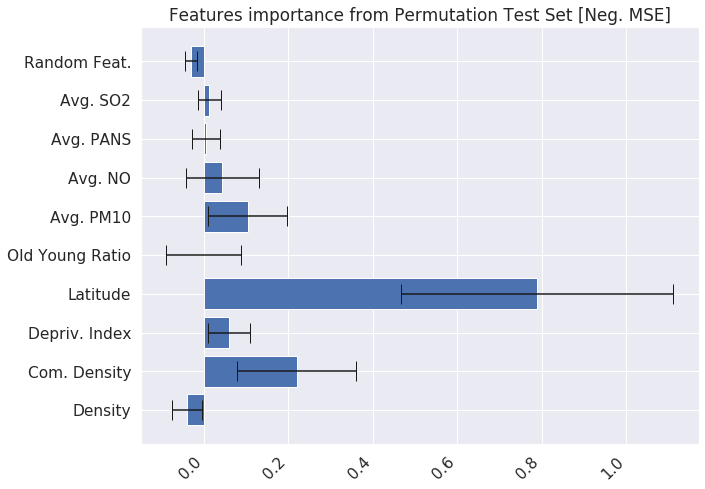

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.08509 +/- 0.05432
Feature:                  Depriv. Index, Score: 0.02266 +/- 0.01922
Feature:                       Latitude, Score: 0.30625 +/- 0.12488
Feature:                      Avg. PM10, Score: 0.04022 +/- 0.03614
Feature:                        Avg. NO, Score: 0.01686 +/- 0.03371
Feature:                      Avg. PANS, Score: 0.00214 +/- 0.01273
Feature:                       Avg. SO2, Score: 0.00493 +/- 0.01033


<Figure size 432x288 with 0 Axes>

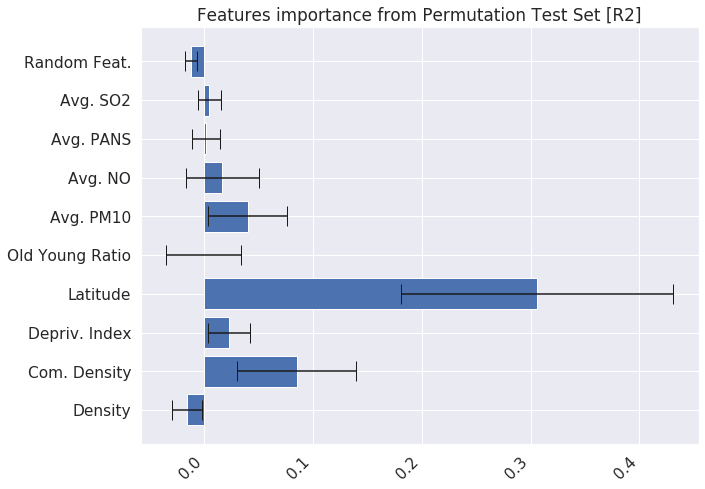

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.06726 +/- 0.00954
Feature:                   Com. Density, Score: 0.23695 +/- 0.04353
Feature:                  Depriv. Index, Score: 0.10435 +/- 0.01724
Feature:                       Latitude, Score: 0.65743 +/- 0.09028
Feature:                Old Young Ratio, Score: 0.11741 +/- 0.01756
Feature:                      Avg. PM10, Score: 0.17932 +/- 0.02397
Feature:                        Avg. NO, Score: 0.19622 +/- 0.02675
Feature:                      Avg. PANS, Score: 0.05433 +/- 0.00587
Feature:                       Avg. SO2, Score: 0.06621 +/- 0.00899


<Figure size 432x288 with 0 Axes>

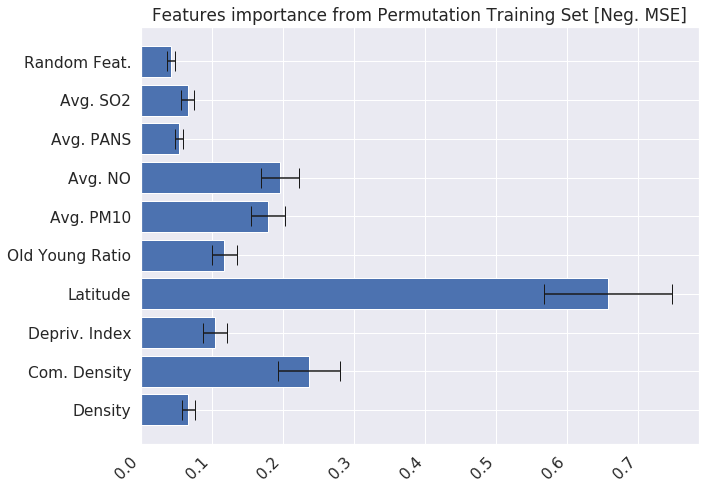

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.03226 +/- 0.00457
Feature:                   Com. Density, Score: 0.11364 +/- 0.02088
Feature:                  Depriv. Index, Score: 0.05005 +/- 0.00827
Feature:                       Latitude, Score: 0.31530 +/- 0.04330
Feature:                Old Young Ratio, Score: 0.05631 +/- 0.00842
Feature:                      Avg. PM10, Score: 0.08600 +/- 0.01150
Feature:                        Avg. NO, Score: 0.09411 +/- 0.01283
Feature:                      Avg. PANS, Score: 0.02606 +/- 0.00282
Feature:                       Avg. SO2, Score: 0.03175 +/- 0.00431


<Figure size 432x288 with 0 Axes>

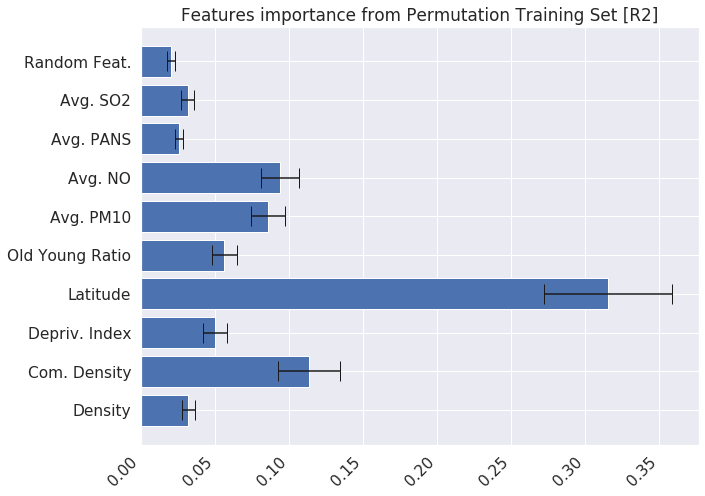

<Figure size 720x720 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.37853  0.02178 
    Test set average RMSE:  1.02605  0.08574 

Prediction STD :    1.25382
True value STD :    1.47826
Difference in percentage:   15.18282

             Fullset RMSE:    0.36697
                       R2:    0.93838


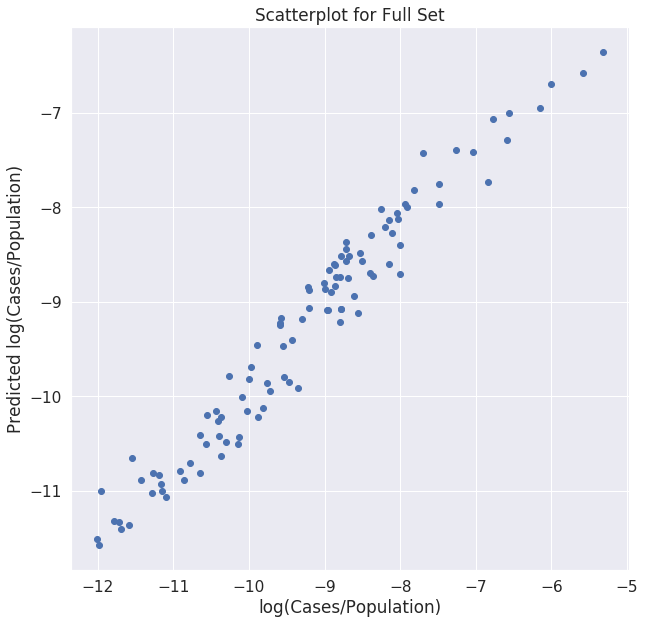

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.09547 +/- 0.01088
Feature:                   Com. Density, Score: 0.65668 +/- 0.08494
Feature:                  Depriv. Index, Score: 0.27322 +/- 0.03259
Feature:                Old Young Ratio, Score: 0.15495 +/- 0.02159
Feature:                      Avg. PM10, Score: 0.31796 +/- 0.04573
Feature:                        Avg. NO, Score: 0.36130 +/- 0.05283
Feature:                      Avg. PANS, Score: 0.08442 +/- 0.01137
Feature:                       Avg. SO2, Score: 0.12205 +/- 0.01381


<Figure size 432x288 with 0 Axes>

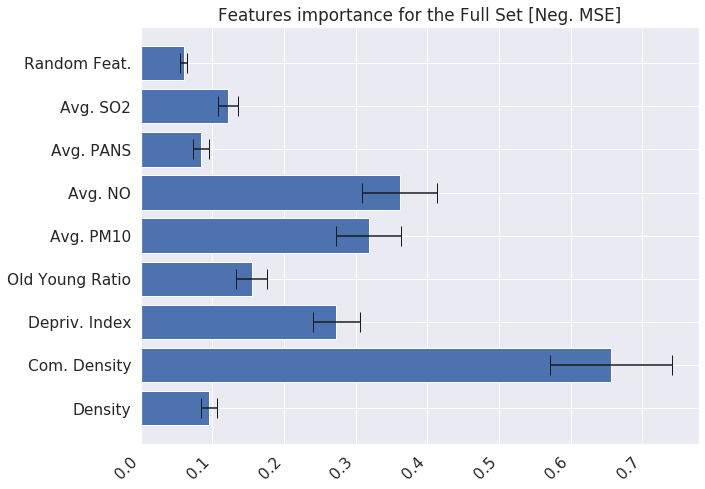

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.04369 +/- 0.00498
Feature:                   Com. Density, Score: 0.30051 +/- 0.03887
Feature:                  Depriv. Index, Score: 0.12503 +/- 0.01491
Feature:                Old Young Ratio, Score: 0.07091 +/- 0.00988
Feature:                      Avg. PM10, Score: 0.14550 +/- 0.02093
Feature:                        Avg. NO, Score: 0.16534 +/- 0.02418
Feature:                      Avg. PANS, Score: 0.03863 +/- 0.00520
Feature:                       Avg. SO2, Score: 0.05585 +/- 0.00632


<Figure size 432x288 with 0 Axes>

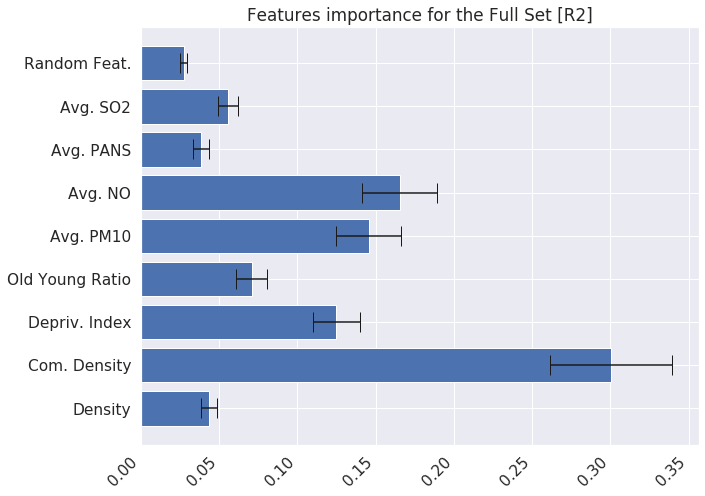

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.35970
                       R2:    0.93795


<Figure size 432x288 with 0 Axes>

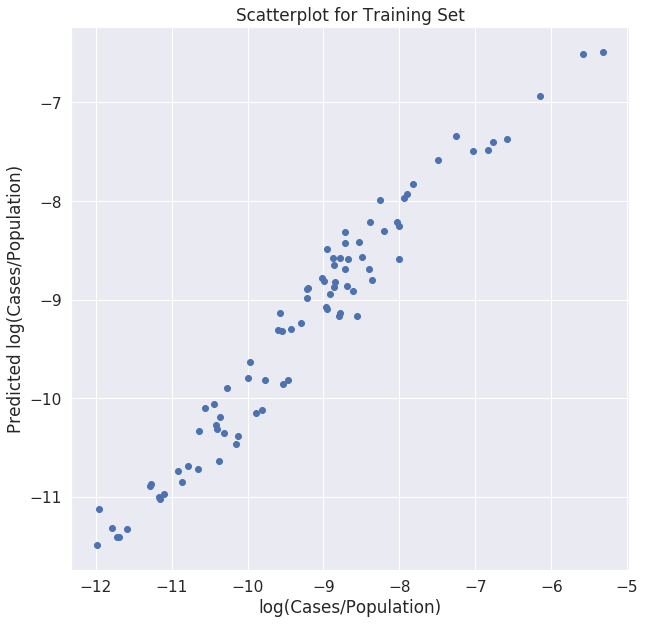

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.11446
                       R2:    0.51817


<Figure size 432x288 with 0 Axes>

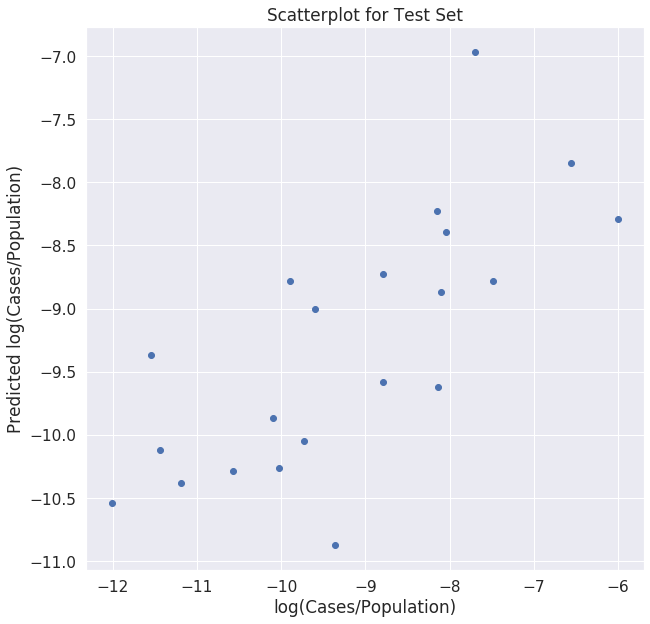

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.73365 +/- 0.29299
Feature:                  Depriv. Index, Score: 0.20148 +/- 0.09602
Feature:                      Avg. PM10, Score: 0.20880 +/- 0.15799
Feature:                        Avg. NO, Score: 0.17079 +/- 0.14710
Feature:                      Avg. PANS, Score: 0.01538 +/- 0.05293
Feature:                       Avg. SO2, Score: 0.03584 +/- 0.04518


<Figure size 432x288 with 0 Axes>

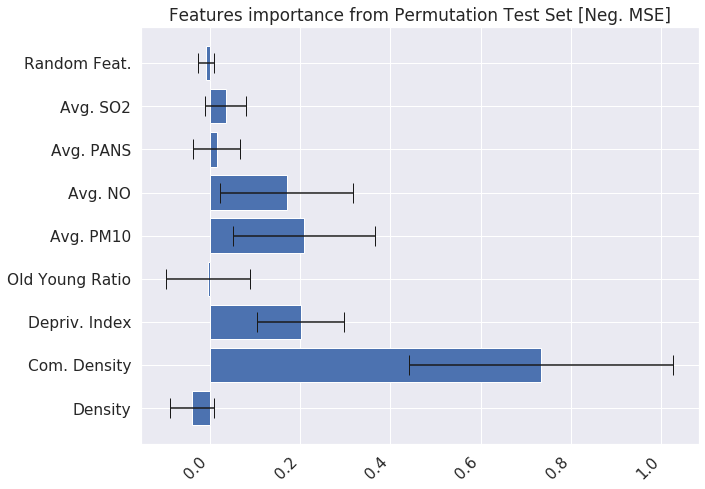

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.28461 +/- 0.11366
Feature:                  Depriv. Index, Score: 0.07816 +/- 0.03725
Feature:                      Avg. PM10, Score: 0.08100 +/- 0.06129
Feature:                        Avg. NO, Score: 0.06625 +/- 0.05707
Feature:                      Avg. PANS, Score: 0.00597 +/- 0.02053
Feature:                       Avg. SO2, Score: 0.01390 +/- 0.01753


<Figure size 432x288 with 0 Axes>

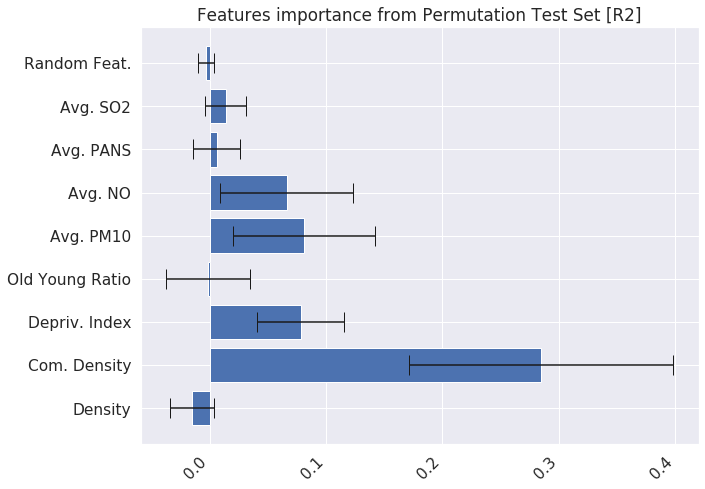

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.08651 +/- 0.01291
Feature:                   Com. Density, Score: 0.58522 +/- 0.09041
Feature:                  Depriv. Index, Score: 0.18482 +/- 0.03198
Feature:                Old Young Ratio, Score: 0.15673 +/- 0.02266
Feature:                      Avg. PM10, Score: 0.28759 +/- 0.04152
Feature:                        Avg. NO, Score: 0.30768 +/- 0.04354
Feature:                      Avg. PANS, Score: 0.08985 +/- 0.01038
Feature:                       Avg. SO2, Score: 0.10214 +/- 0.01658


<Figure size 432x288 with 0 Axes>

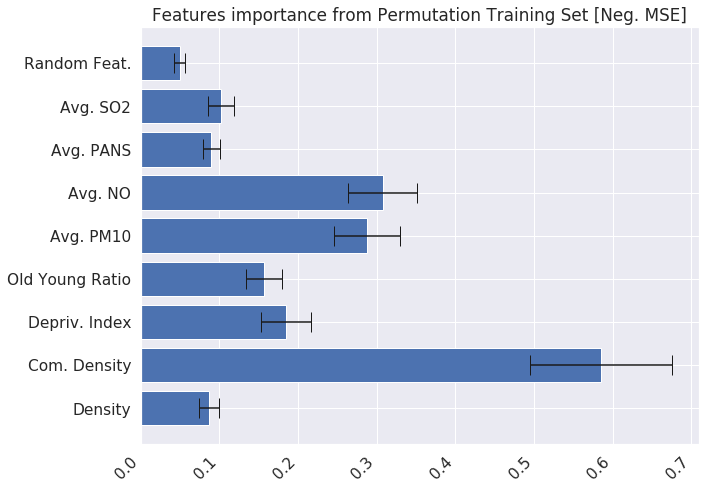

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.04149 +/- 0.00619
Feature:                   Com. Density, Score: 0.28067 +/- 0.04336
Feature:                  Depriv. Index, Score: 0.08864 +/- 0.01534
Feature:                Old Young Ratio, Score: 0.07517 +/- 0.01087
Feature:                      Avg. PM10, Score: 0.13793 +/- 0.01991
Feature:                        Avg. NO, Score: 0.14756 +/- 0.02088
Feature:                      Avg. PANS, Score: 0.04309 +/- 0.00498
Feature:                       Avg. SO2, Score: 0.04899 +/- 0.00795


<Figure size 432x288 with 0 Axes>

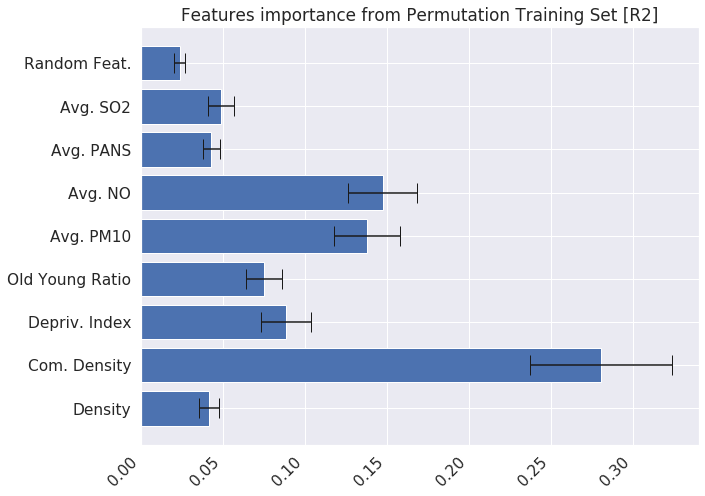

<Figure size 720x720 with 0 Axes>

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_fullset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.39575  0.02455 
    Test set average RMSE:  1.07173  0.11930 

Prediction STD :    1.22311
True value STD :    1.47826
Difference in percentage:   17.26038

             Fullset RMSE:    0.38423
                       R2:    0.93244


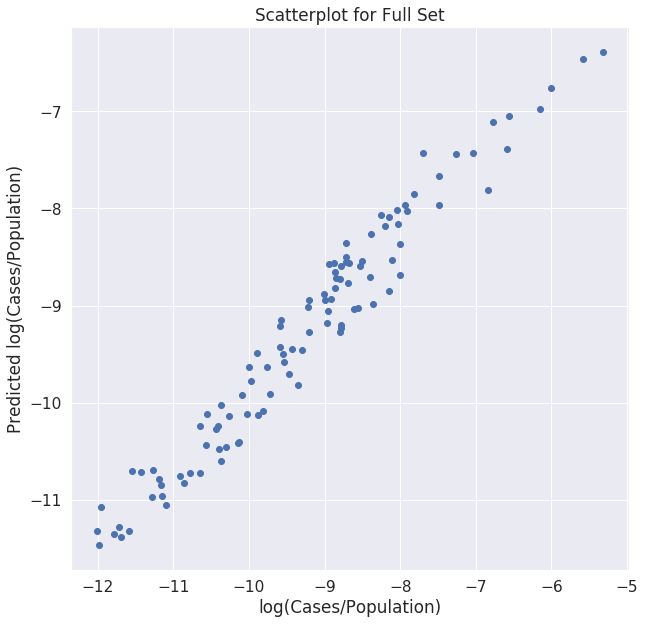

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.13817 +/- 0.01656
Feature:                  Depriv. Index, Score: 0.56323 +/- 0.06757
Feature:                Old Young Ratio, Score: 0.17744 +/- 0.02249
Feature:                      Avg. PM10, Score: 0.48111 +/- 0.06642
Feature:                        Avg. NO, Score: 0.50369 +/- 0.06987
Feature:                      Avg. PANS, Score: 0.13469 +/- 0.01508
Feature:                       Avg. SO2, Score: 0.19446 +/- 0.02260


<Figure size 432x288 with 0 Axes>

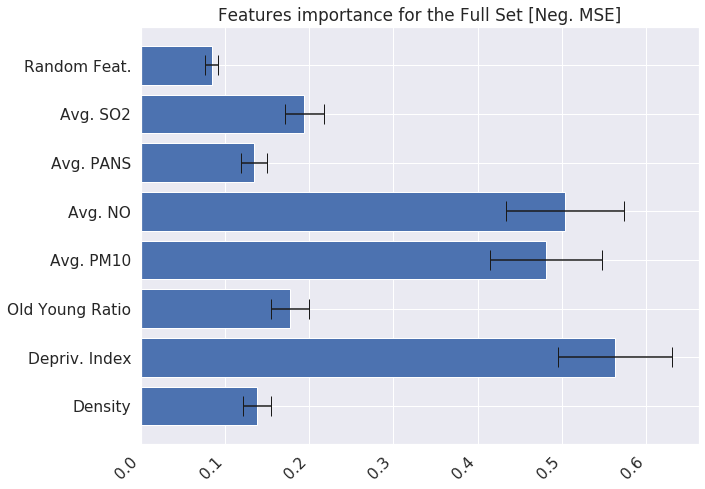

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.06323 +/- 0.00758
Feature:                  Depriv. Index, Score: 0.25774 +/- 0.03092
Feature:                Old Young Ratio, Score: 0.08120 +/- 0.01029
Feature:                      Avg. PM10, Score: 0.22016 +/- 0.03039
Feature:                        Avg. NO, Score: 0.23050 +/- 0.03197
Feature:                      Avg. PANS, Score: 0.06164 +/- 0.00690
Feature:                       Avg. SO2, Score: 0.08899 +/- 0.01034


<Figure size 432x288 with 0 Axes>

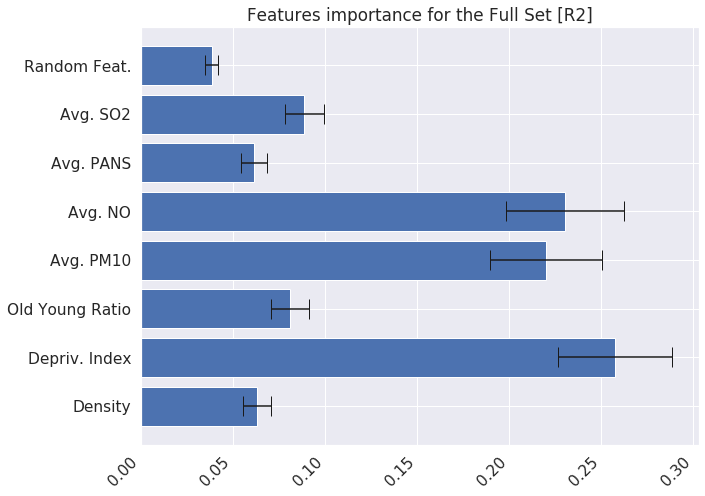

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.37603
                       R2:    0.93218


<Figure size 432x288 with 0 Axes>

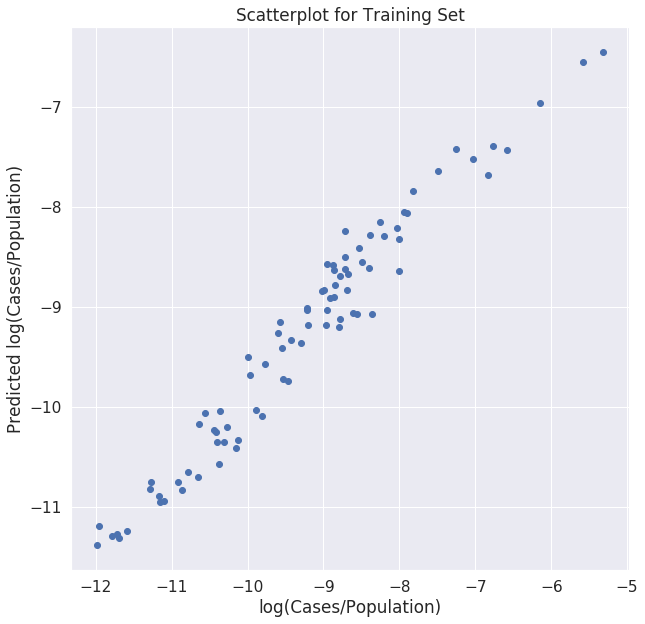

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.21408
                       R2:    0.42818


<Figure size 432x288 with 0 Axes>

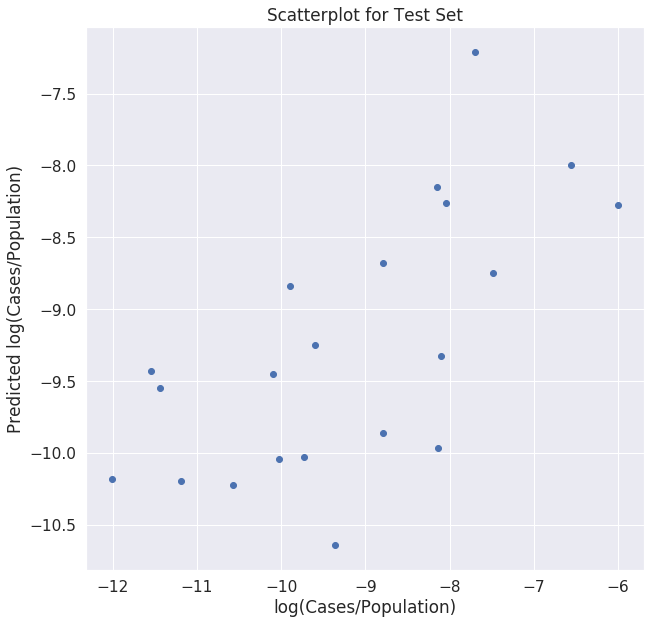

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.55607 +/- 0.19583
Feature:                      Avg. PM10, Score: 0.33635 +/- 0.23613
Feature:                        Avg. NO, Score: 0.30453 +/- 0.21909
Feature:                      Avg. PANS, Score: 0.03972 +/- 0.07468
Feature:                       Avg. SO2, Score: 0.02860 +/- 0.05871


<Figure size 432x288 with 0 Axes>

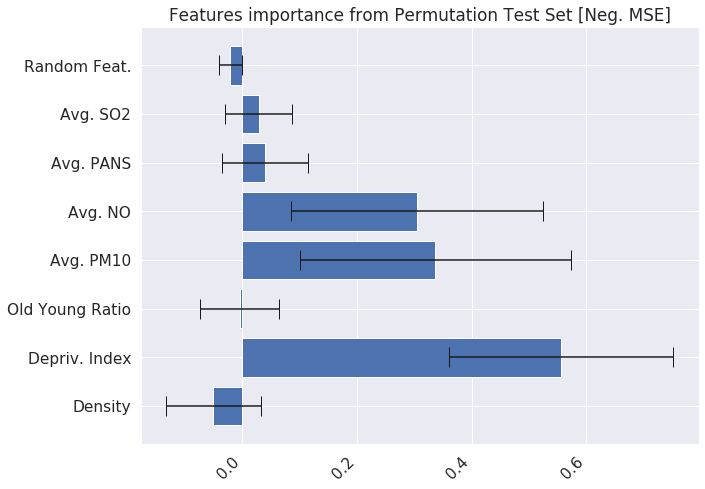

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.21572 +/- 0.07597
Feature:                      Avg. PM10, Score: 0.13048 +/- 0.09161
Feature:                        Avg. NO, Score: 0.11814 +/- 0.08500
Feature:                      Avg. PANS, Score: 0.01541 +/- 0.02897
Feature:                       Avg. SO2, Score: 0.01109 +/- 0.02277


<Figure size 432x288 with 0 Axes>

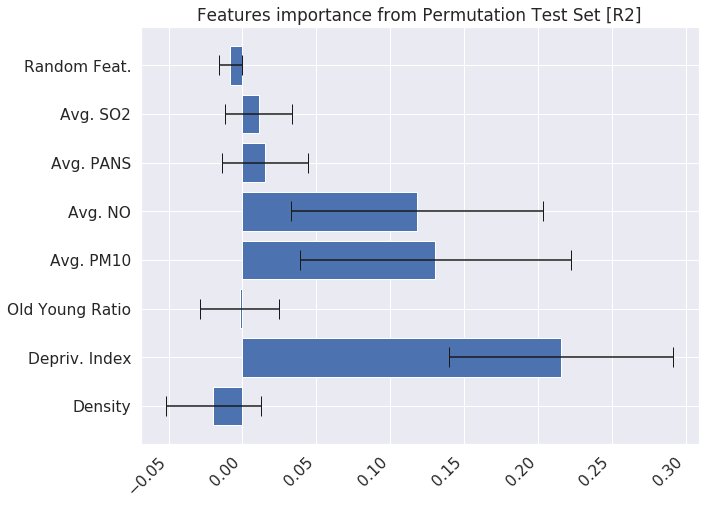

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.14655 +/- 0.01904
Feature:                  Depriv. Index, Score: 0.44271 +/- 0.07326
Feature:                Old Young Ratio, Score: 0.15382 +/- 0.02077
Feature:                      Avg. PM10, Score: 0.41177 +/- 0.05866
Feature:                        Avg. NO, Score: 0.44680 +/- 0.06002
Feature:                      Avg. PANS, Score: 0.13796 +/- 0.01674
Feature:                       Avg. SO2, Score: 0.14664 +/- 0.02449


<Figure size 432x288 with 0 Axes>

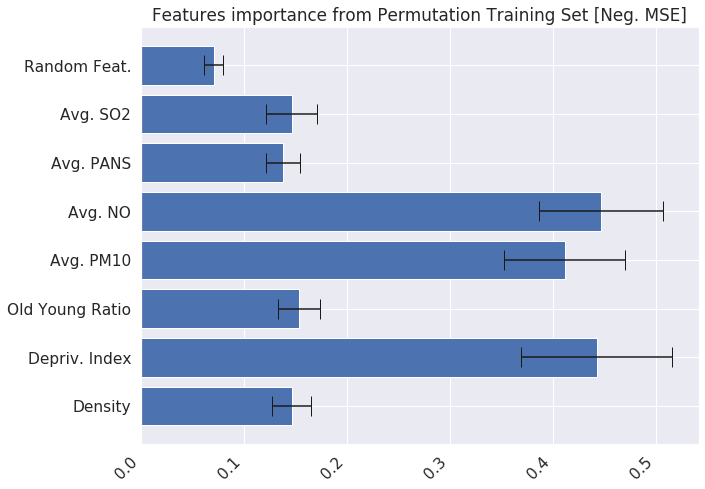

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.07029 +/- 0.00913
Feature:                  Depriv. Index, Score: 0.21232 +/- 0.03513
Feature:                Old Young Ratio, Score: 0.07377 +/- 0.00996
Feature:                      Avg. PM10, Score: 0.19748 +/- 0.02813
Feature:                        Avg. NO, Score: 0.21429 +/- 0.02878
Feature:                      Avg. PANS, Score: 0.06617 +/- 0.00803
Feature:                       Avg. SO2, Score: 0.07033 +/- 0.01175


<Figure size 432x288 with 0 Axes>

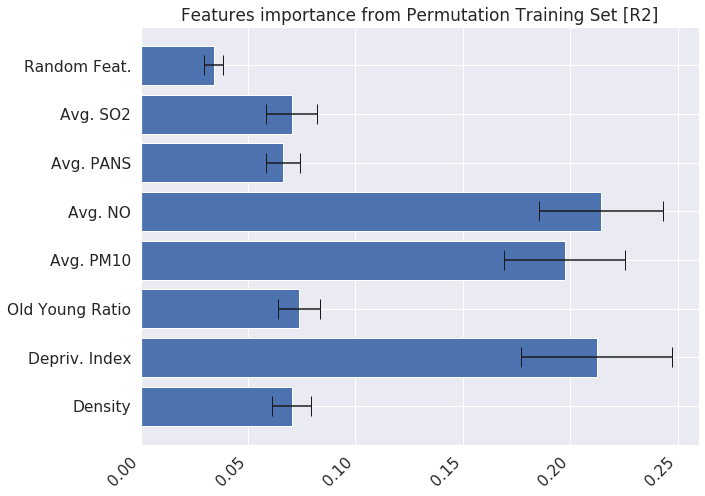

<Figure size 720x720 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse  = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Training Set

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.36271  0.01984 
    Test set average RMSE:  0.94519  0.09020 

Prediction STD :    1.29145
True value STD :    1.47826
Difference in percentage:   12.63735

             Fullset RMSE:    0.34683
                       R2:    0.94495


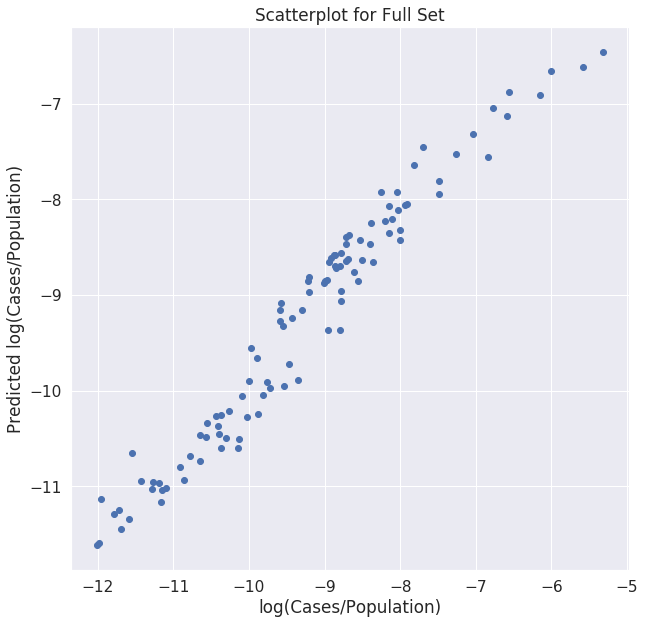

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.06304 +/- 0.00670
Feature:                   Com. Density, Score: 0.25776 +/- 0.04249
Feature:                  Depriv. Index, Score: 0.13388 +/- 0.01519
Feature:                       Latitude, Score: 0.81207 +/- 0.09685
Feature:                Old Young Ratio, Score: 0.11601 +/- 0.01876
Feature:                      Avg. PM10, Score: 0.20828 +/- 0.03075
Feature:                        Avg. NO, Score: 0.21964 +/- 0.02927
Feature:                      Avg. PANS, Score: 0.06146 +/- 0.00805
Feature:                       Avg. SO2, Score: 0.09218 +/- 0.01109


<Figure size 432x288 with 0 Axes>

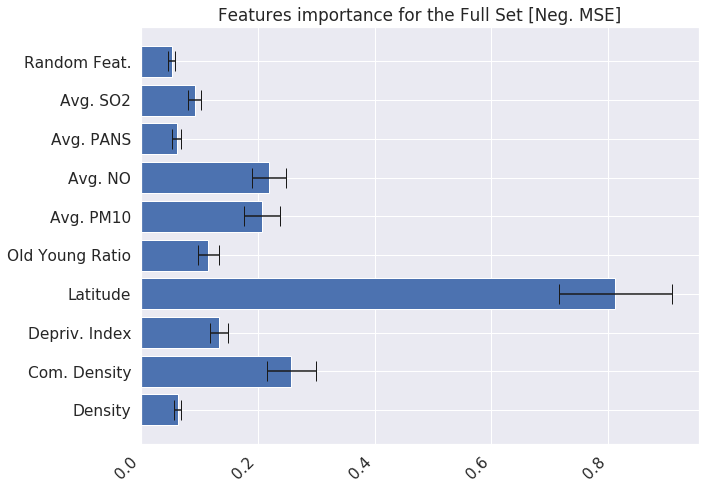

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.02885 +/- 0.00307
Feature:                   Com. Density, Score: 0.11795 +/- 0.01944
Feature:                  Depriv. Index, Score: 0.06127 +/- 0.00695
Feature:                       Latitude, Score: 0.37161 +/- 0.04432
Feature:                Old Young Ratio, Score: 0.05309 +/- 0.00858
Feature:                      Avg. PM10, Score: 0.09531 +/- 0.01407
Feature:                        Avg. NO, Score: 0.10051 +/- 0.01339
Feature:                      Avg. PANS, Score: 0.02812 +/- 0.00368
Feature:                       Avg. SO2, Score: 0.04218 +/- 0.00507


<Figure size 432x288 with 0 Axes>

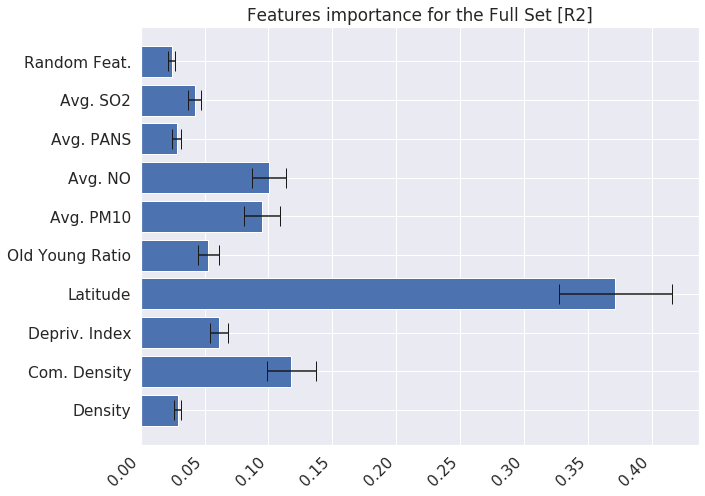

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.33394
                       R2:    0.94652


<Figure size 432x288 with 0 Axes>

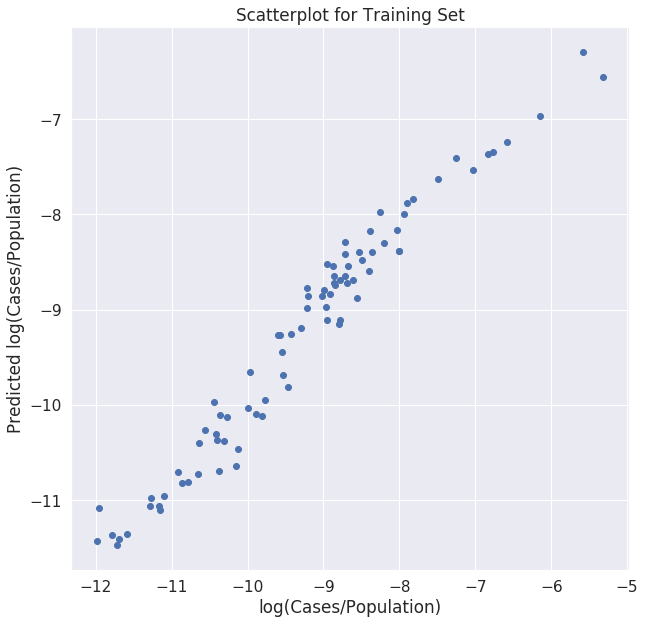

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.06495
                       R2:    0.56003


<Figure size 432x288 with 0 Axes>

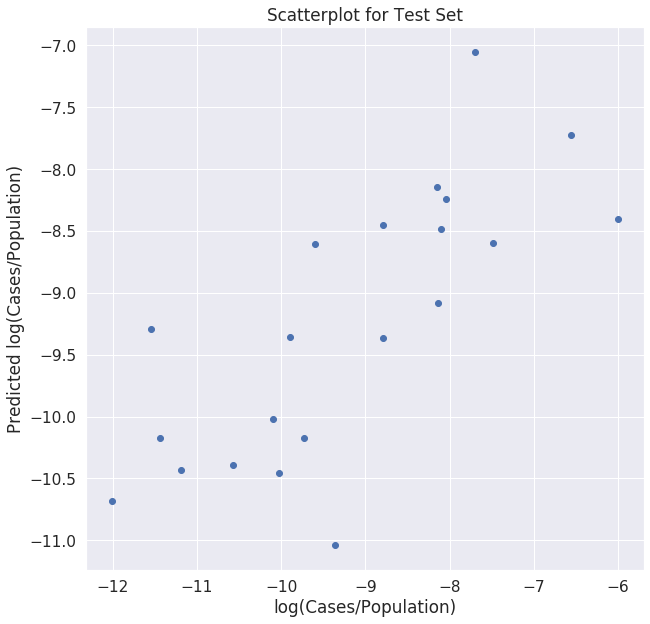

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.26505 +/- 0.16674
Feature:                  Depriv. Index, Score: 0.06248 +/- 0.06226
Feature:                       Latitude, Score: 0.72548 +/- 0.30013
Feature:                      Avg. PM10, Score: 0.13058 +/- 0.12178
Feature:                        Avg. NO, Score: 0.02972 +/- 0.09293
Feature:                      Avg. PANS, Score: 0.00103 +/- 0.03090
Feature:                       Avg. SO2, Score: 0.01231 +/- 0.03997


<Figure size 432x288 with 0 Axes>

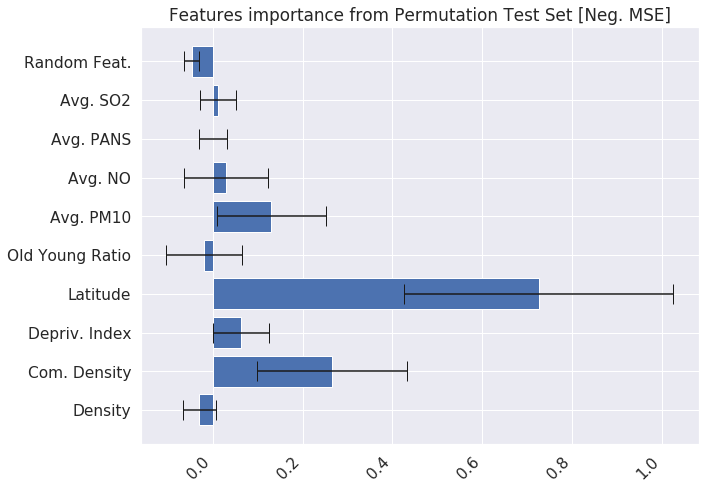

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.10282 +/- 0.06468
Feature:                  Depriv. Index, Score: 0.02424 +/- 0.02415
Feature:                       Latitude, Score: 0.28144 +/- 0.11643
Feature:                      Avg. PM10, Score: 0.05066 +/- 0.04724
Feature:                        Avg. NO, Score: 0.01153 +/- 0.03605
Feature:                      Avg. PANS, Score: 0.00040 +/- 0.01199
Feature:                       Avg. SO2, Score: 0.00478 +/- 0.01551


<Figure size 432x288 with 0 Axes>

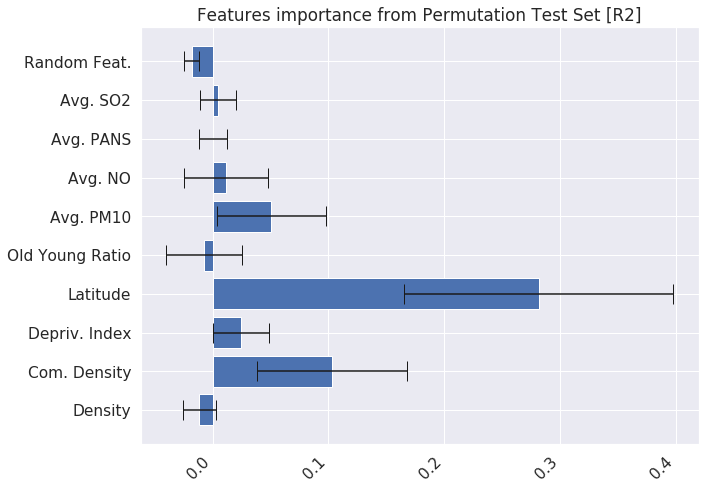

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.07023 +/- 0.00915
Feature:                   Com. Density, Score: 0.28157 +/- 0.04790
Feature:                  Depriv. Index, Score: 0.11602 +/- 0.02022
Feature:                       Latitude, Score: 0.56280 +/- 0.07899
Feature:                Old Young Ratio, Score: 0.11946 +/- 0.01571
Feature:                      Avg. PM10, Score: 0.18947 +/- 0.02685
Feature:                        Avg. NO, Score: 0.18452 +/- 0.02472
Feature:                      Avg. PANS, Score: 0.05043 +/- 0.00675
Feature:                       Avg. SO2, Score: 0.07805 +/- 0.01186


<Figure size 432x288 with 0 Axes>

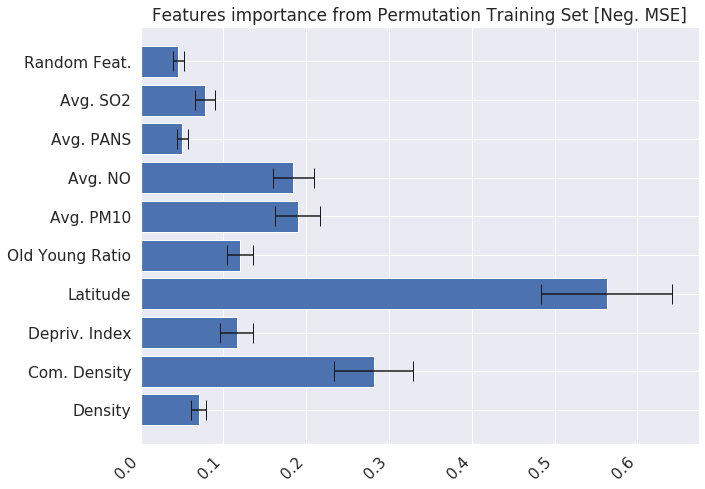

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.03368 +/- 0.00439
Feature:                   Com. Density, Score: 0.13504 +/- 0.02297
Feature:                  Depriv. Index, Score: 0.05565 +/- 0.00970
Feature:                       Latitude, Score: 0.26992 +/- 0.03788
Feature:                Old Young Ratio, Score: 0.05729 +/- 0.00753
Feature:                      Avg. PM10, Score: 0.09087 +/- 0.01288
Feature:                        Avg. NO, Score: 0.08849 +/- 0.01186
Feature:                      Avg. PANS, Score: 0.02419 +/- 0.00324
Feature:                       Avg. SO2, Score: 0.03743 +/- 0.00569


<Figure size 432x288 with 0 Axes>

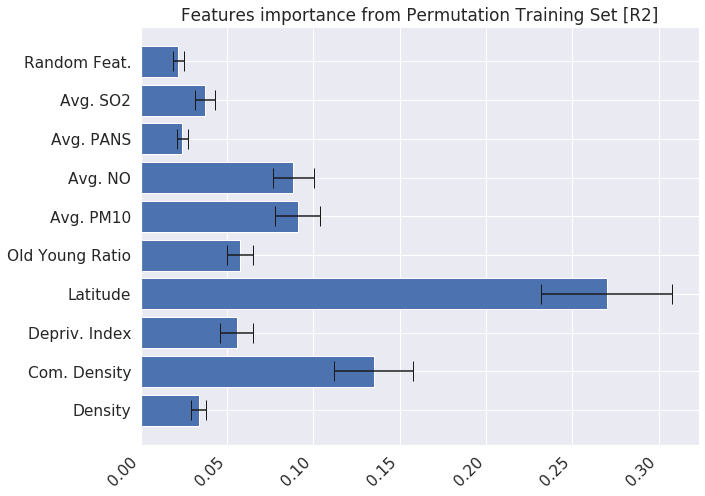

<Figure size 720x720 with 0 Axes>

In [11]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.37231  0.02294 
    Test set average RMSE:  1.03115  0.09663 

Prediction STD :    1.25496
True value STD :    1.47826
Difference in percentage:   15.10530

             Fullset RMSE:    0.36785
                       R2:    0.93808


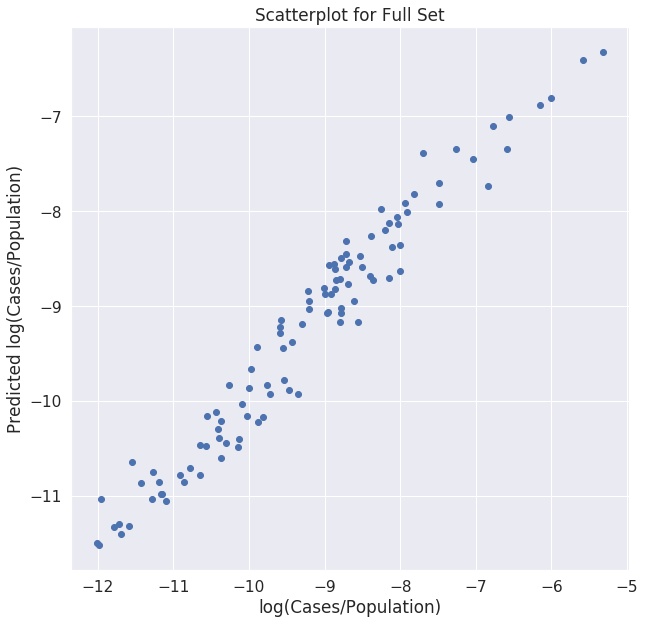

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.08633 +/- 0.00899
Feature:                   Com. Density, Score: 0.69923 +/- 0.09027
Feature:                  Depriv. Index, Score: 0.25112 +/- 0.03019
Feature:                Old Young Ratio, Score: 0.15339 +/- 0.02185
Feature:                      Avg. PM10, Score: 0.30013 +/- 0.04432
Feature:                        Avg. NO, Score: 0.37098 +/- 0.05490
Feature:                      Avg. PANS, Score: 0.08217 +/- 0.01088
Feature:                       Avg. SO2, Score: 0.12816 +/- 0.01437


<Figure size 432x288 with 0 Axes>

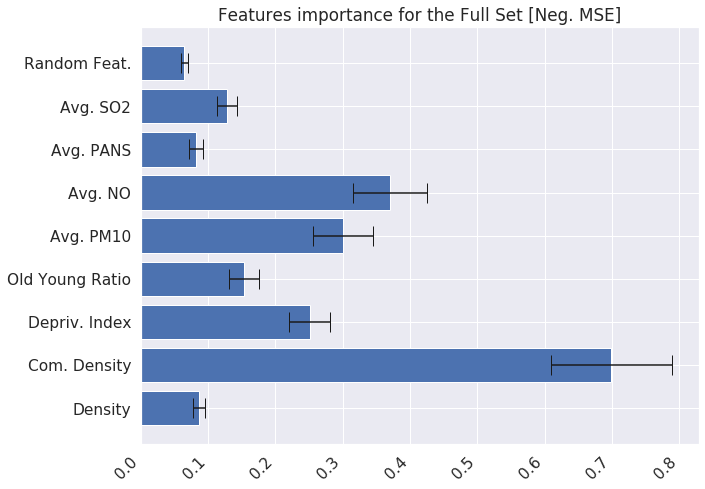

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.03951 +/- 0.00411
Feature:                   Com. Density, Score: 0.31998 +/- 0.04131
Feature:                  Depriv. Index, Score: 0.11492 +/- 0.01381
Feature:                Old Young Ratio, Score: 0.07020 +/- 0.01000
Feature:                      Avg. PM10, Score: 0.13734 +/- 0.02028
Feature:                        Avg. NO, Score: 0.16976 +/- 0.02512
Feature:                      Avg. PANS, Score: 0.03760 +/- 0.00498
Feature:                       Avg. SO2, Score: 0.05865 +/- 0.00658


<Figure size 432x288 with 0 Axes>

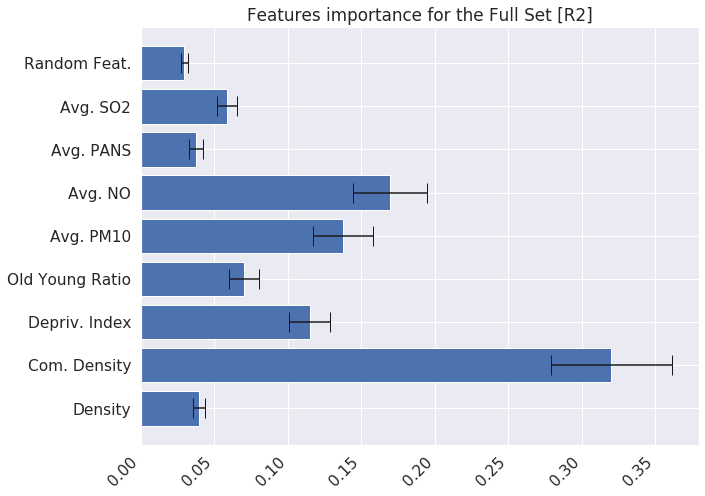

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.36051
                       R2:    0.93767


<Figure size 432x288 with 0 Axes>

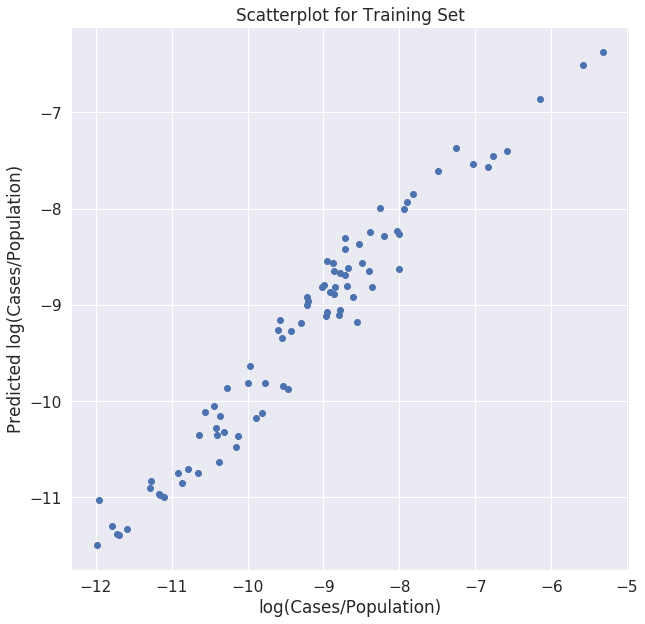

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.11492
                       R2:    0.51777


<Figure size 432x288 with 0 Axes>

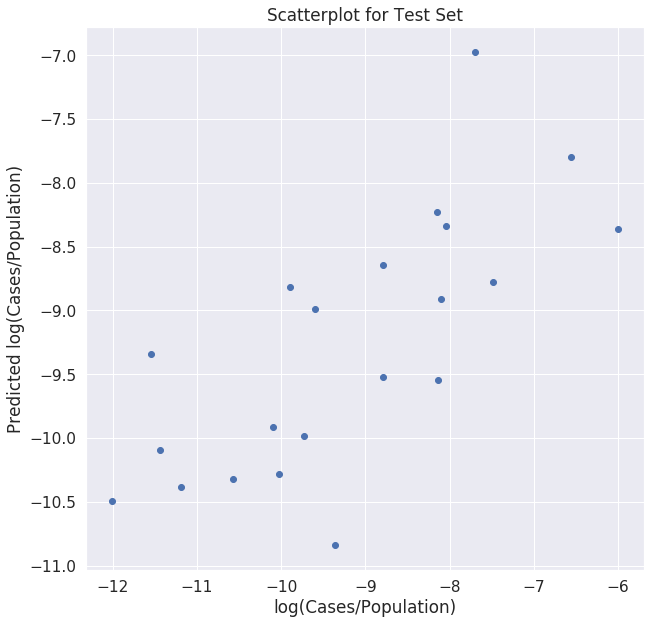

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.73993 +/- 0.29816
Feature:                  Depriv. Index, Score: 0.20686 +/- 0.09777
Feature:                      Avg. PM10, Score: 0.19223 +/- 0.14806
Feature:                        Avg. NO, Score: 0.17574 +/- 0.15030
Feature:                      Avg. PANS, Score: 0.02680 +/- 0.05513
Feature:                       Avg. SO2, Score: 0.02622 +/- 0.04139


<Figure size 432x288 with 0 Axes>

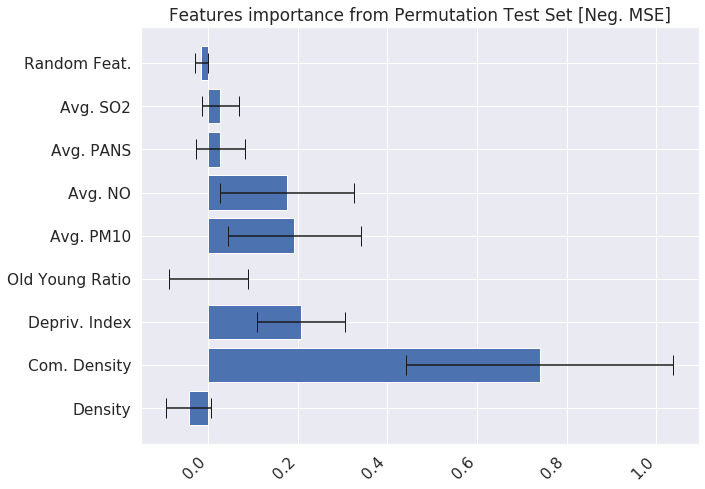

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.28705 +/- 0.11567
Feature:                  Depriv. Index, Score: 0.08025 +/- 0.03793
Feature:                      Avg. PM10, Score: 0.07457 +/- 0.05744
Feature:                        Avg. NO, Score: 0.06818 +/- 0.05831
Feature:                      Avg. PANS, Score: 0.01040 +/- 0.02139
Feature:                       Avg. SO2, Score: 0.01017 +/- 0.01606


<Figure size 432x288 with 0 Axes>

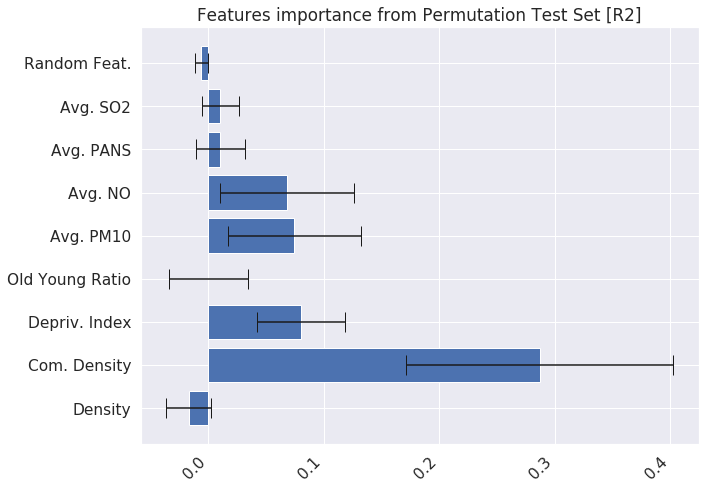

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.09099 +/- 0.01370
Feature:                   Com. Density, Score: 0.60107 +/- 0.09130
Feature:                  Depriv. Index, Score: 0.18679 +/- 0.03208
Feature:                Old Young Ratio, Score: 0.14085 +/- 0.01865
Feature:                      Avg. PM10, Score: 0.25791 +/- 0.03578
Feature:                        Avg. NO, Score: 0.32550 +/- 0.04619
Feature:                      Avg. PANS, Score: 0.09204 +/- 0.01130
Feature:                       Avg. SO2, Score: 0.09798 +/- 0.01541


<Figure size 432x288 with 0 Axes>

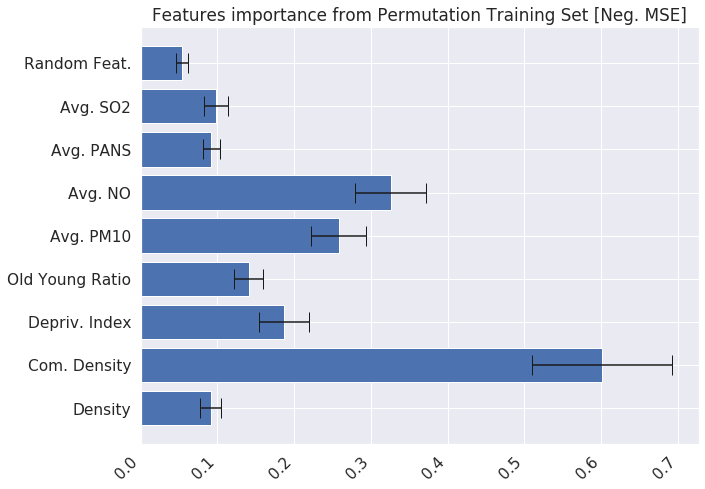

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.04364 +/- 0.00657
Feature:                   Com. Density, Score: 0.28827 +/- 0.04379
Feature:                  Depriv. Index, Score: 0.08958 +/- 0.01538
Feature:                Old Young Ratio, Score: 0.06755 +/- 0.00894
Feature:                      Avg. PM10, Score: 0.12369 +/- 0.01716
Feature:                        Avg. NO, Score: 0.15611 +/- 0.02215
Feature:                      Avg. PANS, Score: 0.04414 +/- 0.00542
Feature:                       Avg. SO2, Score: 0.04699 +/- 0.00739


<Figure size 432x288 with 0 Axes>

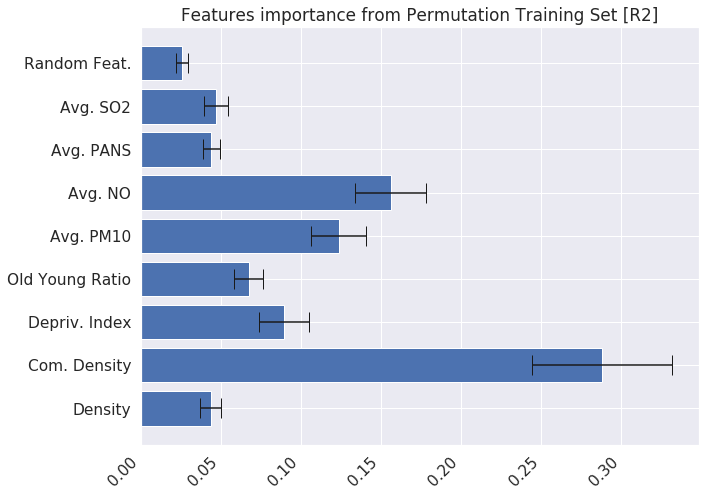

<Figure size 720x720 with 0 Axes>

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_traininingset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.39471  0.02416 
    Test set average RMSE:  1.08693  0.10593 

Prediction STD :    1.22151
True value STD :    1.47826
Difference in percentage:   17.36867

             Fullset RMSE:    0.38556
                       R2:    0.93197


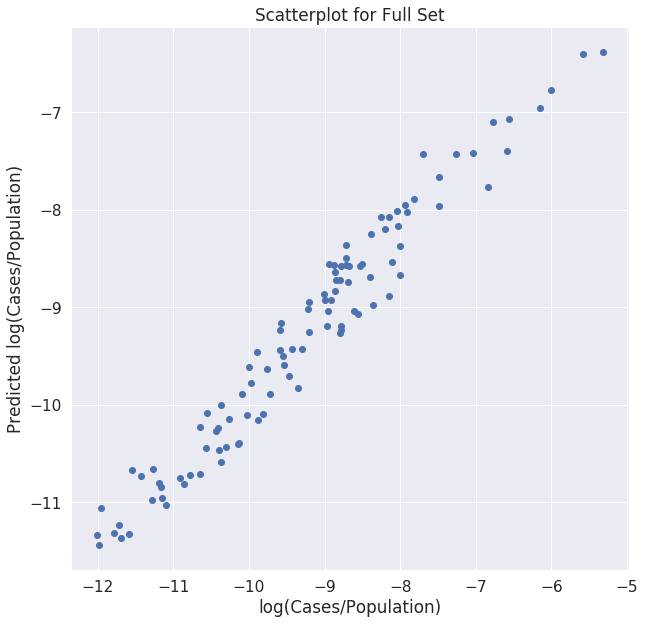

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.14014 +/- 0.01692
Feature:                  Depriv. Index, Score: 0.54868 +/- 0.06525
Feature:                Old Young Ratio, Score: 0.17591 +/- 0.02243
Feature:                      Avg. PM10, Score: 0.47923 +/- 0.06592
Feature:                        Avg. NO, Score: 0.51795 +/- 0.07220
Feature:                      Avg. PANS, Score: 0.13497 +/- 0.01520
Feature:                       Avg. SO2, Score: 0.19364 +/- 0.02198


<Figure size 432x288 with 0 Axes>

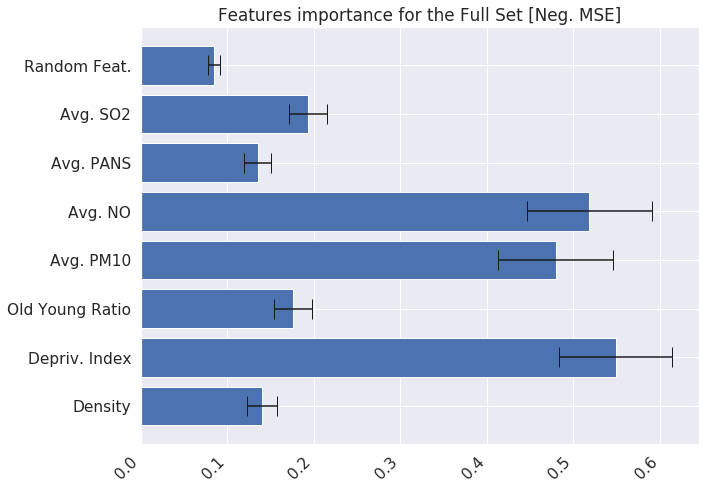

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.06413 +/- 0.00774
Feature:                  Depriv. Index, Score: 0.25108 +/- 0.02986
Feature:                Old Young Ratio, Score: 0.08050 +/- 0.01026
Feature:                      Avg. PM10, Score: 0.21930 +/- 0.03017
Feature:                        Avg. NO, Score: 0.23702 +/- 0.03304
Feature:                      Avg. PANS, Score: 0.06176 +/- 0.00695
Feature:                       Avg. SO2, Score: 0.08861 +/- 0.01006


<Figure size 432x288 with 0 Axes>

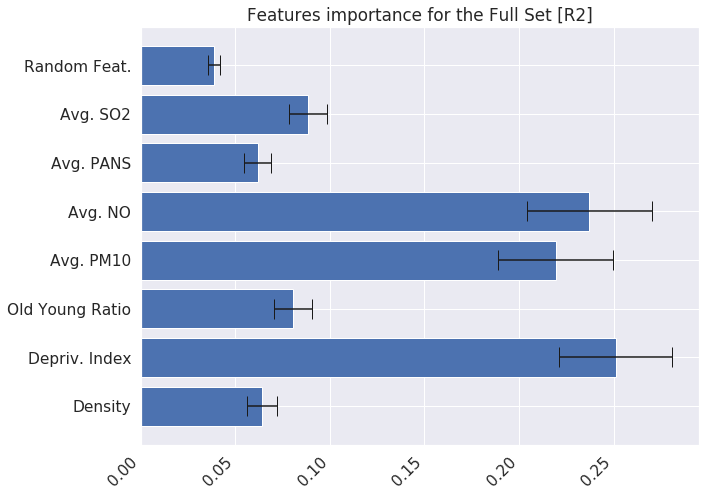

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.37632
                       R2:    0.93208


<Figure size 432x288 with 0 Axes>

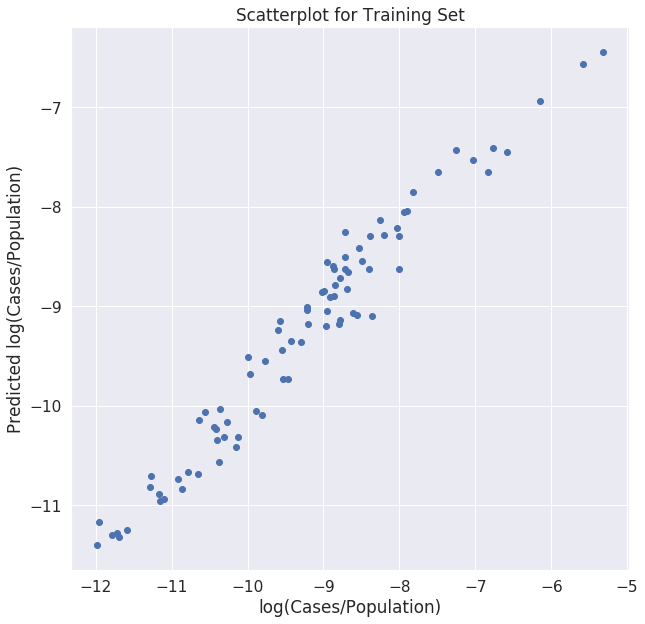

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.21022
                       R2:    0.43181


<Figure size 432x288 with 0 Axes>

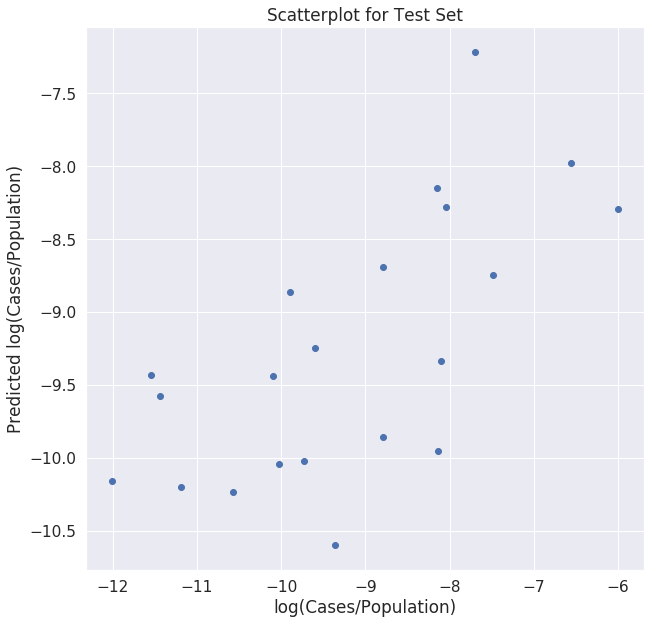

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.55012 +/- 0.19447
Feature:                      Avg. PM10, Score: 0.33409 +/- 0.22933
Feature:                        Avg. NO, Score: 0.31862 +/- 0.21989
Feature:                      Avg. PANS, Score: 0.03960 +/- 0.07397
Feature:                       Avg. SO2, Score: 0.03842 +/- 0.06162


<Figure size 432x288 with 0 Axes>

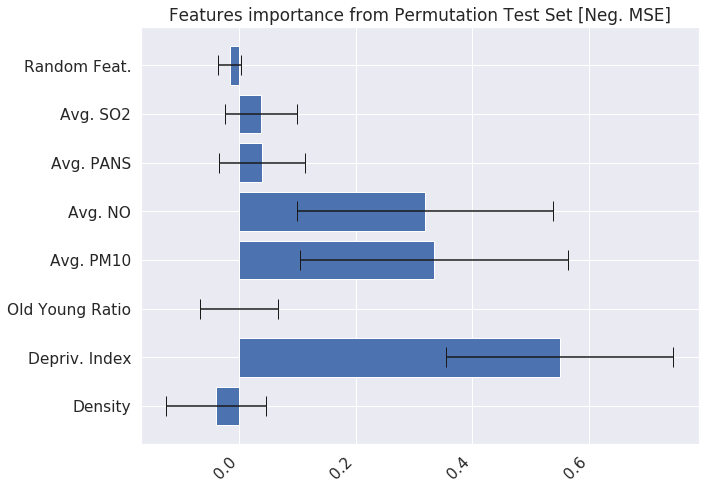

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.21341 +/- 0.07544
Feature:                      Avg. PM10, Score: 0.12961 +/- 0.08897
Feature:                        Avg. NO, Score: 0.12361 +/- 0.08530
Feature:                      Avg. PANS, Score: 0.01536 +/- 0.02870
Feature:                       Avg. SO2, Score: 0.01490 +/- 0.02390


<Figure size 432x288 with 0 Axes>

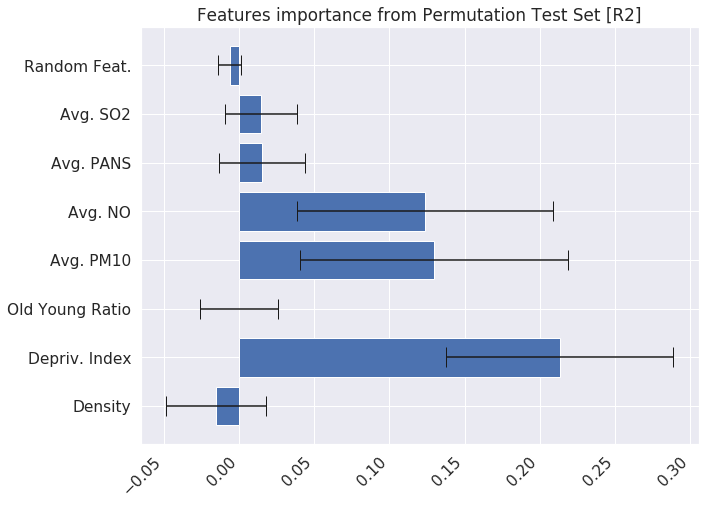

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.14739 +/- 0.01945
Feature:                  Depriv. Index, Score: 0.43013 +/- 0.07064
Feature:                Old Young Ratio, Score: 0.15303 +/- 0.02104
Feature:                      Avg. PM10, Score: 0.41023 +/- 0.05892
Feature:                        Avg. NO, Score: 0.45727 +/- 0.06168
Feature:                      Avg. PANS, Score: 0.13452 +/- 0.01641
Feature:                       Avg. SO2, Score: 0.15010 +/- 0.02600


<Figure size 432x288 with 0 Axes>

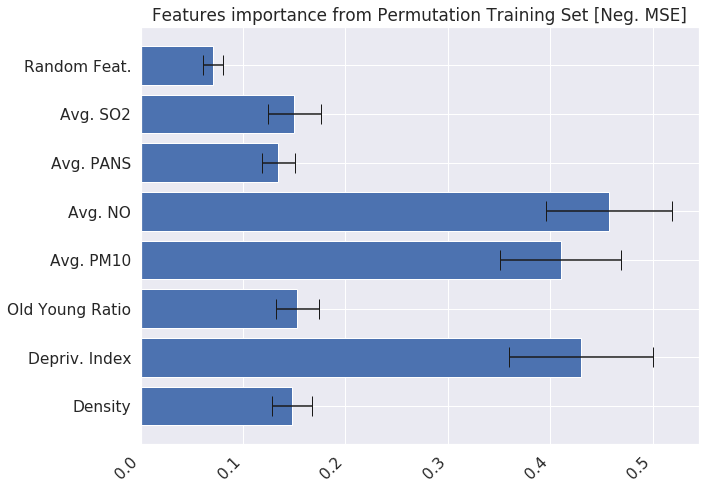

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.07069 +/- 0.00933
Feature:                  Depriv. Index, Score: 0.20629 +/- 0.03388
Feature:                Old Young Ratio, Score: 0.07339 +/- 0.01009
Feature:                      Avg. PM10, Score: 0.19675 +/- 0.02826
Feature:                        Avg. NO, Score: 0.21931 +/- 0.02958
Feature:                      Avg. PANS, Score: 0.06452 +/- 0.00787
Feature:                       Avg. SO2, Score: 0.07199 +/- 0.01247


<Figure size 432x288 with 0 Axes>

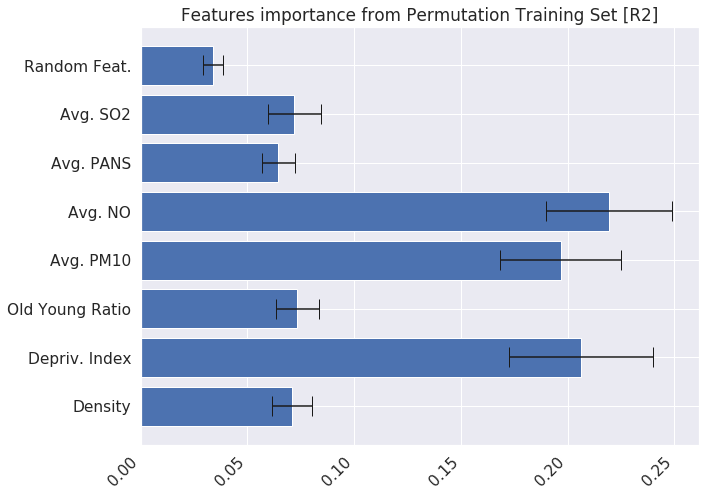

<Figure size 720x720 with 0 Axes>

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Test Set 

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.79035  0.04732 
    Test set average RMSE:  0.91990  0.09770 

Prediction STD :    1.20626
True value STD :    1.47826
Difference in percentage:   18.39968

             Fullset RMSE:    0.77200
                       R2:    0.72727


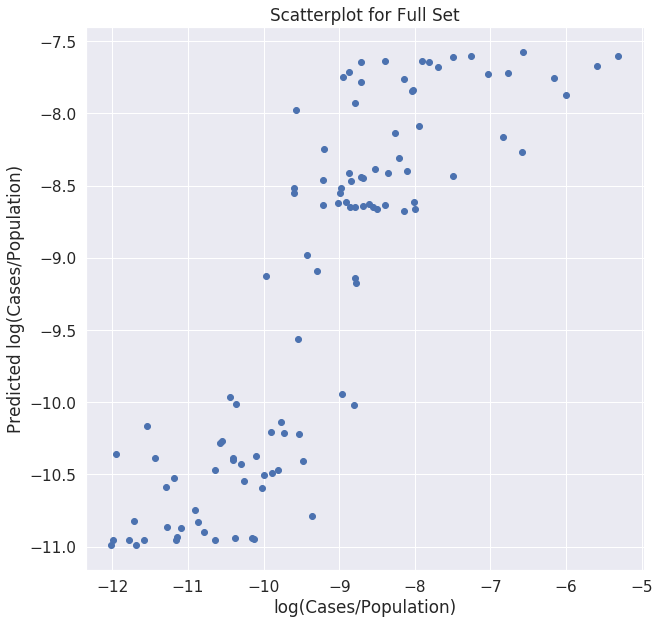

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.00284 +/- 0.00182
Feature:                  Depriv. Index, Score: 0.00400 +/- 0.00111
Feature:                       Latitude, Score: 2.37538 +/- 0.30502
Feature:                Old Young Ratio, Score: 0.03445 +/- 0.01393
Feature:                      Avg. PM10, Score: 0.02505 +/- 0.01237
Feature:                        Avg. NO, Score: 0.12725 +/- 0.03712
Feature:                      Avg. PANS, Score: 0.00269 +/- 0.00156
Feature:                       Avg. SO2, Score: 0.00573 +/- 0.00146


<Figure size 432x288 with 0 Axes>

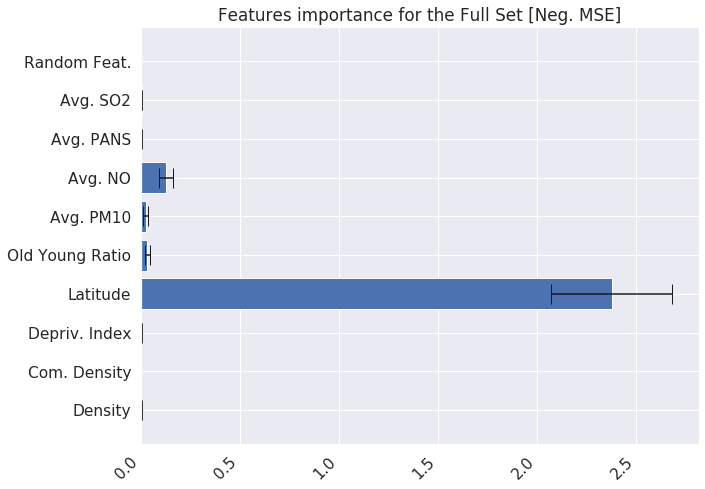

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.00130 +/- 0.00083
Feature:                  Depriv. Index, Score: 0.00183 +/- 0.00051
Feature:                       Latitude, Score: 1.08701 +/- 0.13958
Feature:                Old Young Ratio, Score: 0.01577 +/- 0.00637
Feature:                      Avg. PM10, Score: 0.01146 +/- 0.00566
Feature:                        Avg. NO, Score: 0.05823 +/- 0.01699
Feature:                      Avg. PANS, Score: 0.00123 +/- 0.00072
Feature:                       Avg. SO2, Score: 0.00262 +/- 0.00067


<Figure size 432x288 with 0 Axes>

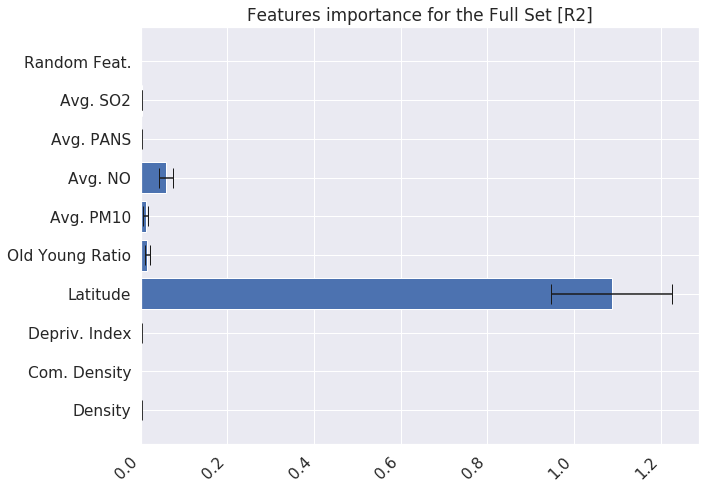

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.76025
                       R2:    0.72280


<Figure size 432x288 with 0 Axes>

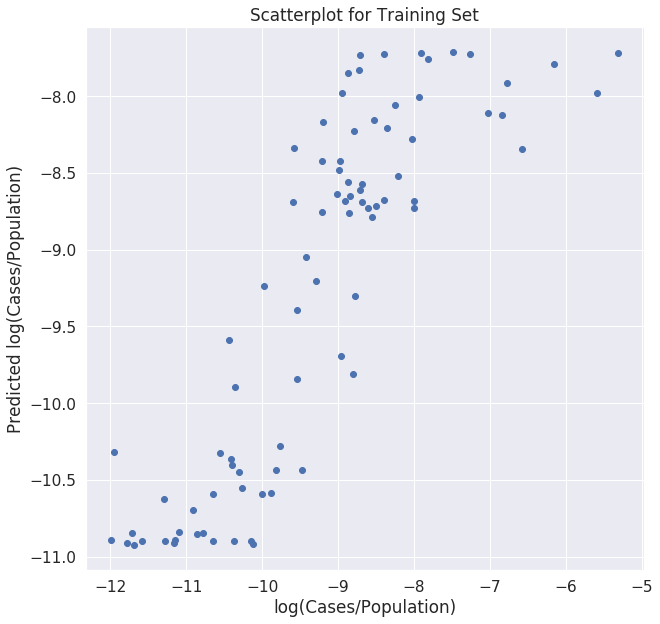

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.97293
                       R2:    0.63278


<Figure size 432x288 with 0 Axes>

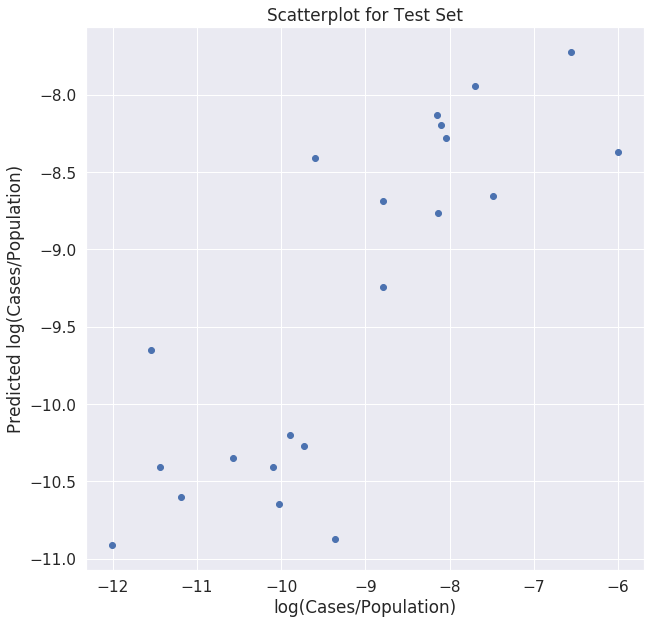

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.01522 +/- 0.01799
Feature:                       Latitude, Score: 2.55389 +/- 0.85625
Feature:                Old Young Ratio, Score: 0.01266 +/- 0.08231
Feature:                      Avg. PM10, Score: 0.03240 +/- 0.01494
Feature:                        Avg. NO, Score: 0.08835 +/- 0.05324
Feature:                       Avg. SO2, Score: 0.00687 +/- 0.00322


<Figure size 432x288 with 0 Axes>

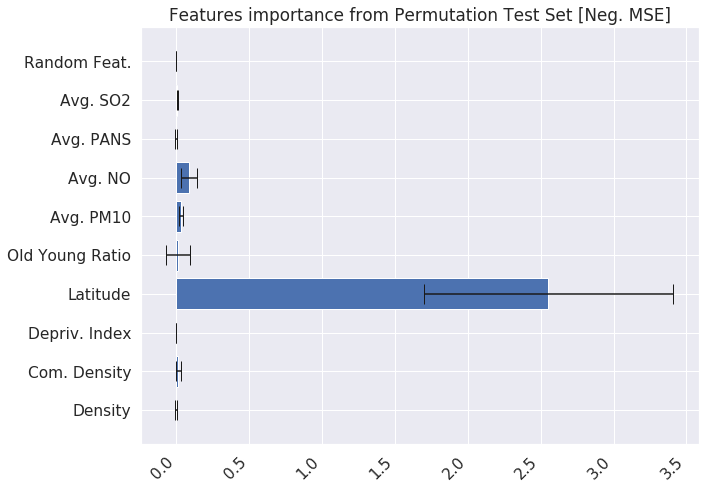

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.00590 +/- 0.00698
Feature:                       Latitude, Score: 0.99076 +/- 0.33217
Feature:                Old Young Ratio, Score: 0.00491 +/- 0.03193
Feature:                      Avg. PM10, Score: 0.01257 +/- 0.00579
Feature:                        Avg. NO, Score: 0.03427 +/- 0.02065
Feature:                       Avg. SO2, Score: 0.00266 +/- 0.00125


<Figure size 432x288 with 0 Axes>

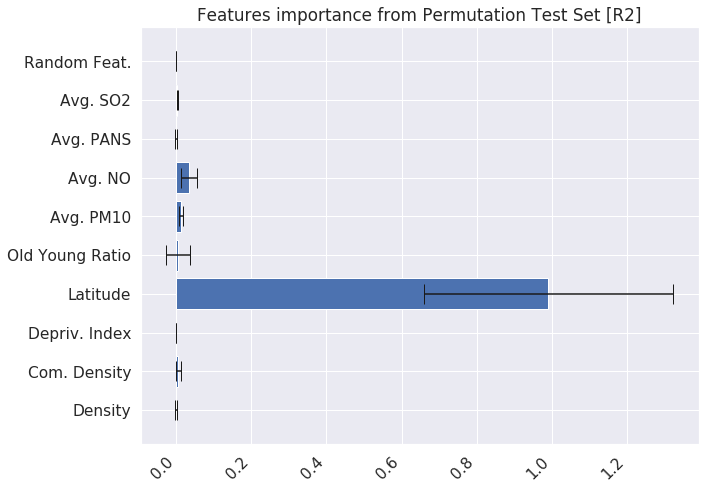

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.00290 +/- 0.00257
Feature:                   Com. Density, Score: 0.00508 +/- 0.00727
Feature:                       Latitude, Score: 2.14409 +/- 0.28206
Feature:                Old Young Ratio, Score: 0.07745 +/- 0.02863
Feature:                      Avg. PM10, Score: 0.00354 +/- 0.00610
Feature:                        Avg. NO, Score: 0.07632 +/- 0.02681
Feature:                      Avg. PANS, Score: 0.00261 +/- 0.00195
Feature:                       Avg. SO2, Score: 0.00322 +/- 0.00132


<Figure size 432x288 with 0 Axes>

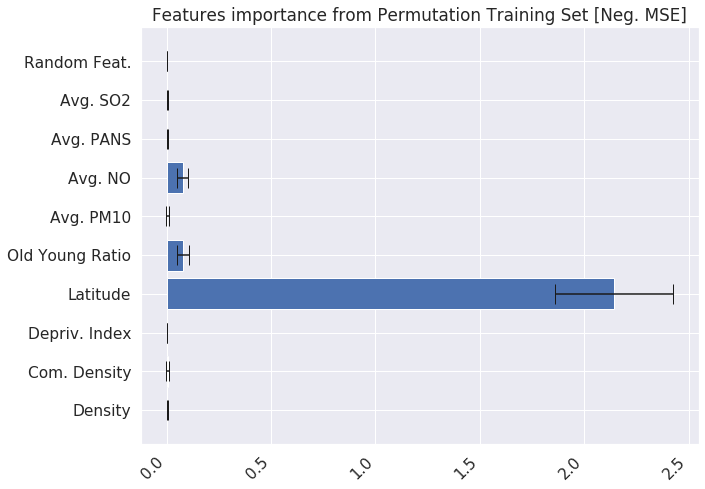

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.00139 +/- 0.00123
Feature:                   Com. Density, Score: 0.00244 +/- 0.00349
Feature:                       Latitude, Score: 1.02830 +/- 0.13528
Feature:                Old Young Ratio, Score: 0.03714 +/- 0.01373
Feature:                      Avg. PM10, Score: 0.00170 +/- 0.00292
Feature:                        Avg. NO, Score: 0.03660 +/- 0.01286
Feature:                      Avg. PANS, Score: 0.00125 +/- 0.00093
Feature:                       Avg. SO2, Score: 0.00154 +/- 0.00063


<Figure size 432x288 with 0 Axes>

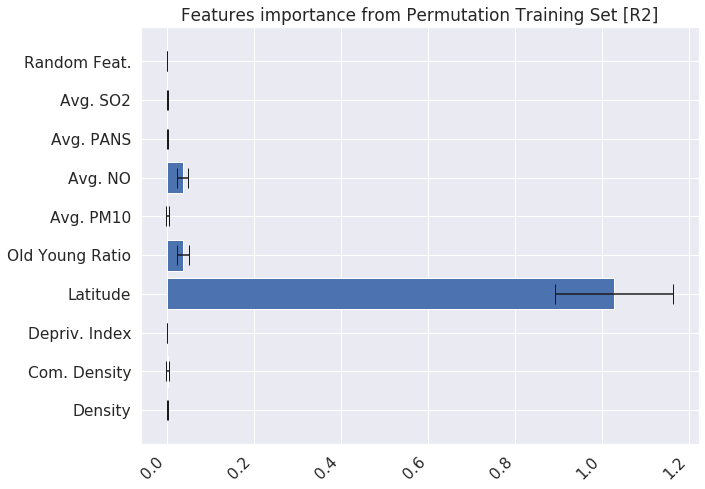

<Figure size 720x720 with 0 Axes>

In [14]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.38198  0.02751 
    Test set average RMSE:  1.01661  0.11114 

Prediction STD :    1.25360
True value STD :    1.47826
Difference in percentage:   15.19736

             Fullset RMSE:    0.36881
                       R2:    0.93775


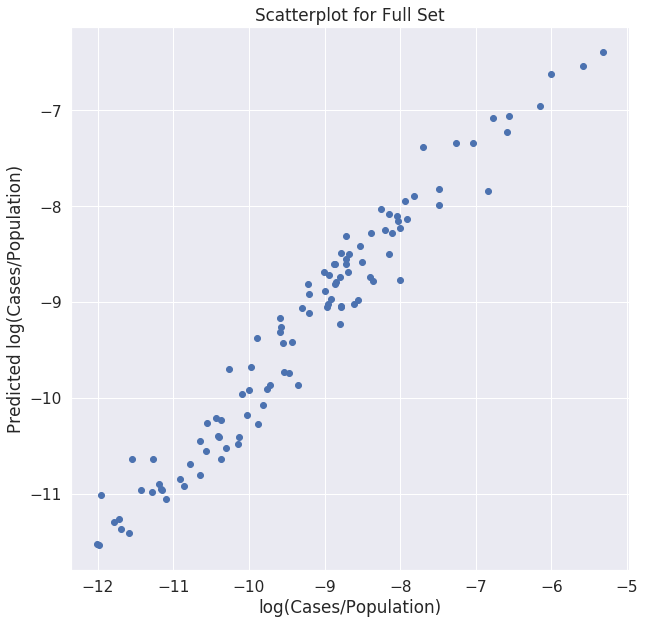

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.10106 +/- 0.01345
Feature:                   Com. Density, Score: 0.66594 +/- 0.08521
Feature:                  Depriv. Index, Score: 0.29469 +/- 0.03601
Feature:                Old Young Ratio, Score: 0.13526 +/- 0.02047
Feature:                      Avg. PM10, Score: 0.32034 +/- 0.04314
Feature:                        Avg. NO, Score: 0.34808 +/- 0.05089
Feature:                      Avg. PANS, Score: 0.09018 +/- 0.01312
Feature:                       Avg. SO2, Score: 0.11938 +/- 0.01350


<Figure size 432x288 with 0 Axes>

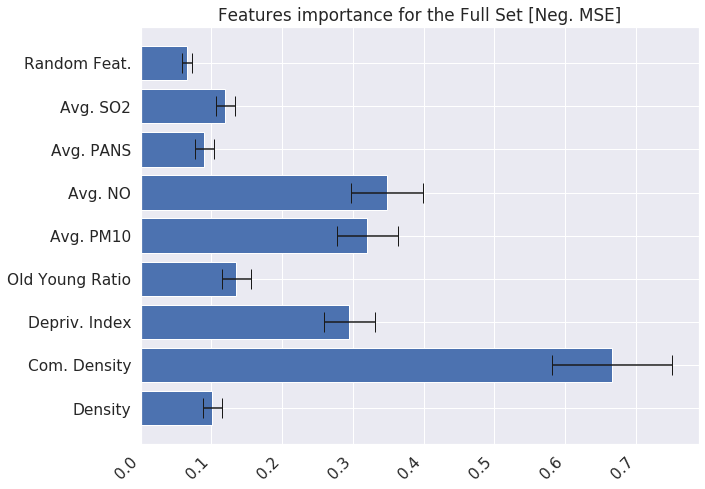

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.04625 +/- 0.00616
Feature:                   Com. Density, Score: 0.30474 +/- 0.03900
Feature:                  Depriv. Index, Score: 0.13486 +/- 0.01648
Feature:                Old Young Ratio, Score: 0.06190 +/- 0.00937
Feature:                      Avg. PM10, Score: 0.14659 +/- 0.01974
Feature:                        Avg. NO, Score: 0.15928 +/- 0.02329
Feature:                      Avg. PANS, Score: 0.04127 +/- 0.00600
Feature:                       Avg. SO2, Score: 0.05463 +/- 0.00618


<Figure size 432x288 with 0 Axes>

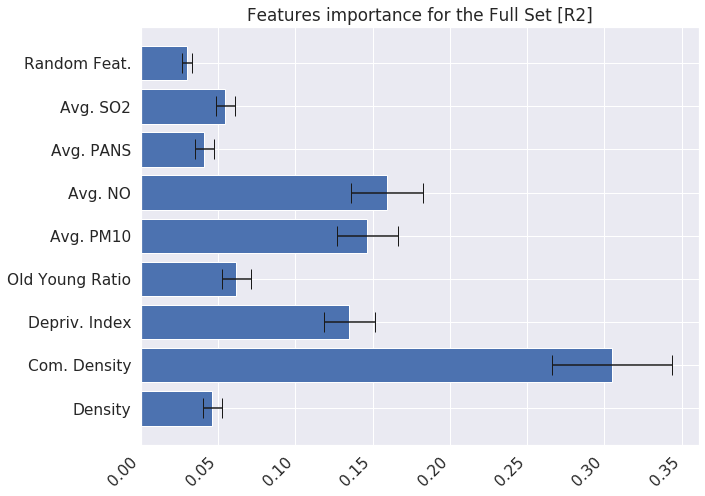

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.36276
                       R2:    0.93689


<Figure size 432x288 with 0 Axes>

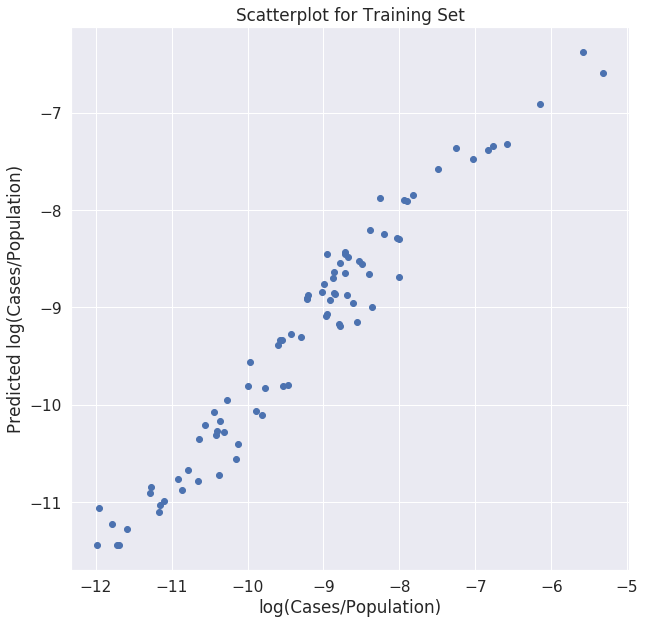

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.11310
                       R2:    0.51934


<Figure size 432x288 with 0 Axes>

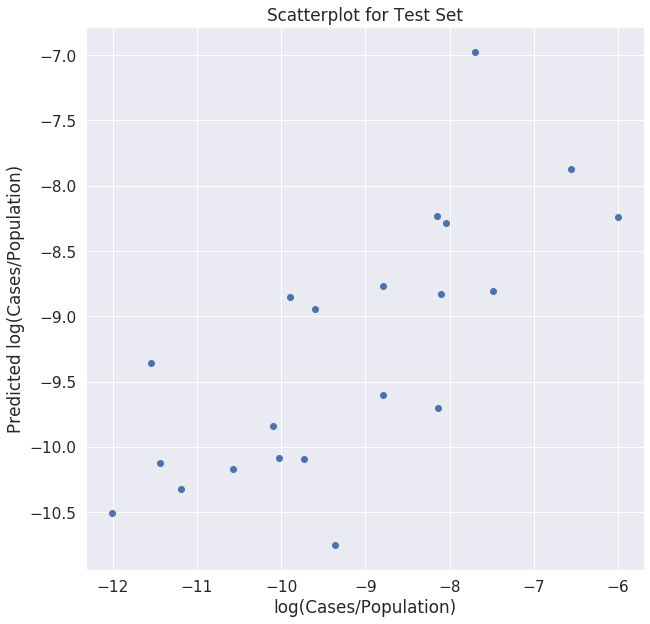

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.69520 +/- 0.28696
Feature:                  Depriv. Index, Score: 0.19130 +/- 0.10098
Feature:                      Avg. PM10, Score: 0.22972 +/- 0.17469
Feature:                        Avg. NO, Score: 0.17398 +/- 0.14185
Feature:                      Avg. PANS, Score: 0.02864 +/- 0.06158
Feature:                       Avg. SO2, Score: 0.01122 +/- 0.04328


<Figure size 432x288 with 0 Axes>

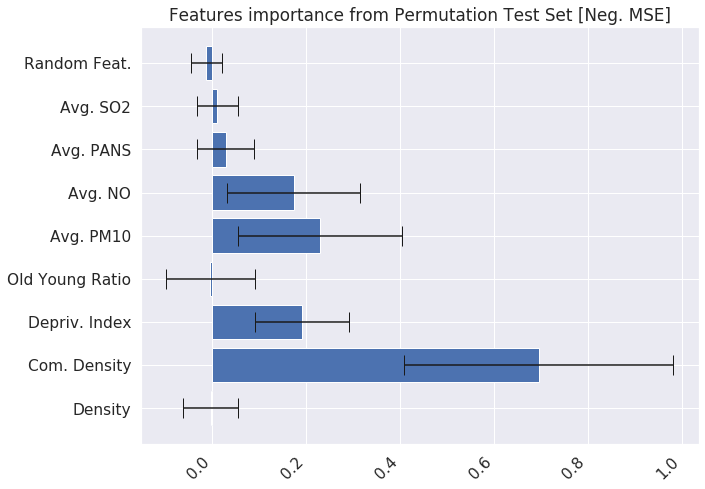

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.26970 +/- 0.11132
Feature:                  Depriv. Index, Score: 0.07421 +/- 0.03917
Feature:                      Avg. PM10, Score: 0.08912 +/- 0.06777
Feature:                        Avg. NO, Score: 0.06749 +/- 0.05503
Feature:                      Avg. PANS, Score: 0.01111 +/- 0.02389
Feature:                       Avg. SO2, Score: 0.00435 +/- 0.01679


<Figure size 432x288 with 0 Axes>

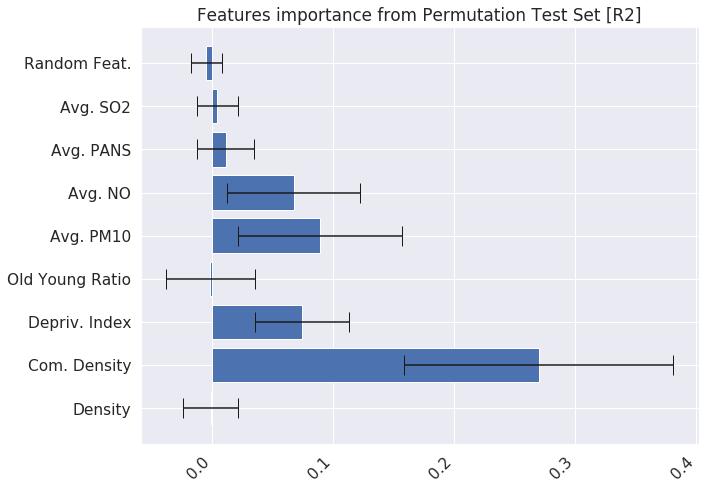

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.08554 +/- 0.01326
Feature:                   Com. Density, Score: 0.59181 +/- 0.08831
Feature:                  Depriv. Index, Score: 0.18085 +/- 0.03240
Feature:                Old Young Ratio, Score: 0.14693 +/- 0.02395
Feature:                      Avg. PM10, Score: 0.30670 +/- 0.04277
Feature:                        Avg. NO, Score: 0.28645 +/- 0.04061
Feature:                      Avg. PANS, Score: 0.09499 +/- 0.01119
Feature:                       Avg. SO2, Score: 0.10386 +/- 0.01643


<Figure size 432x288 with 0 Axes>

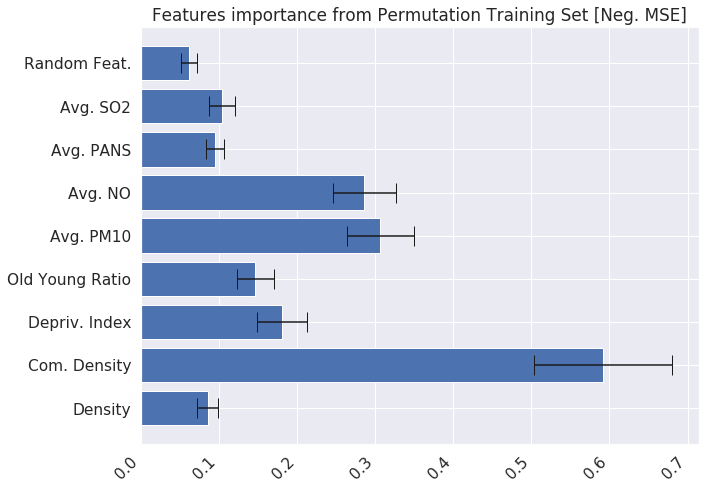

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.04103 +/- 0.00636
Feature:                   Com. Density, Score: 0.28383 +/- 0.04235
Feature:                  Depriv. Index, Score: 0.08673 +/- 0.01554
Feature:                Old Young Ratio, Score: 0.07047 +/- 0.01149
Feature:                      Avg. PM10, Score: 0.14709 +/- 0.02051
Feature:                        Avg. NO, Score: 0.13738 +/- 0.01948
Feature:                      Avg. PANS, Score: 0.04556 +/- 0.00537
Feature:                       Avg. SO2, Score: 0.04981 +/- 0.00788


<Figure size 432x288 with 0 Axes>

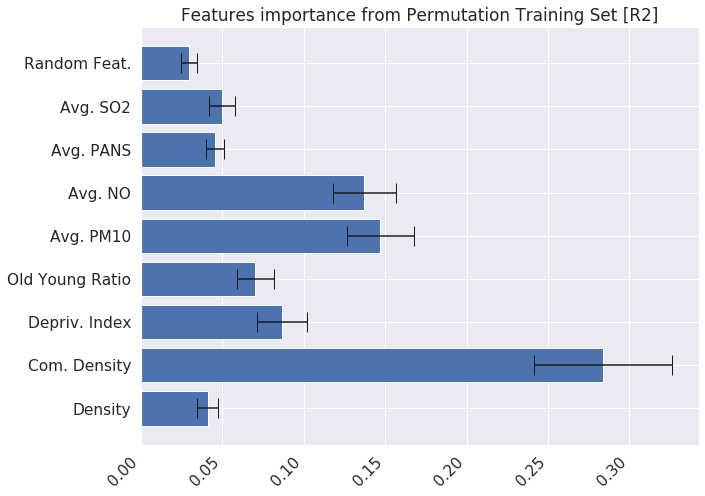

<Figure size 720x720 with 0 Axes>

In [15]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_testset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.40588  0.03155 
    Test set average RMSE:  1.10134  0.13872 

Prediction STD :    1.23896
True value STD :    1.47826
Difference in percentage:   16.18821

             Fullset RMSE:    0.39257
                       R2:    0.92948


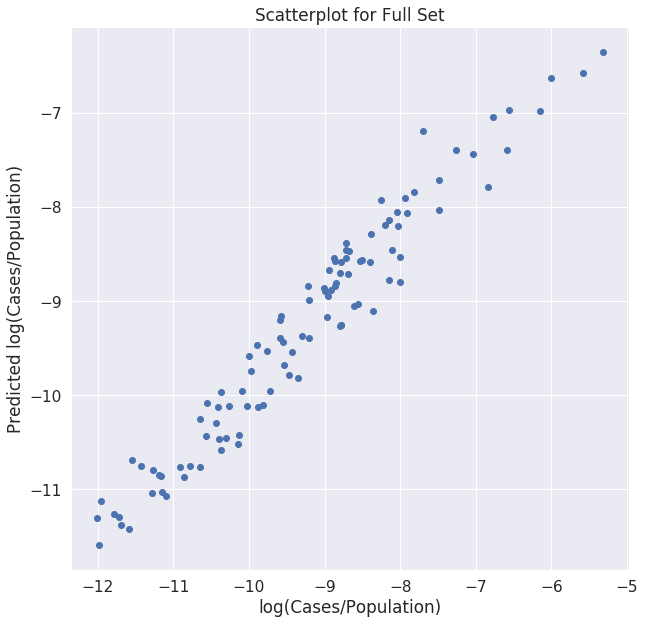

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.67057 +/- 0.07947
Feature:                Old Young Ratio, Score: 0.19015 +/- 0.02893
Feature:                      Avg. PM10, Score: 0.46462 +/- 0.06311
Feature:                        Avg. NO, Score: 0.83022 +/- 0.11969
Feature:                      Avg. PANS, Score: 0.12114 +/- 0.01550
Feature:                       Avg. SO2, Score: 0.12152 +/- 0.01346


<Figure size 432x288 with 0 Axes>

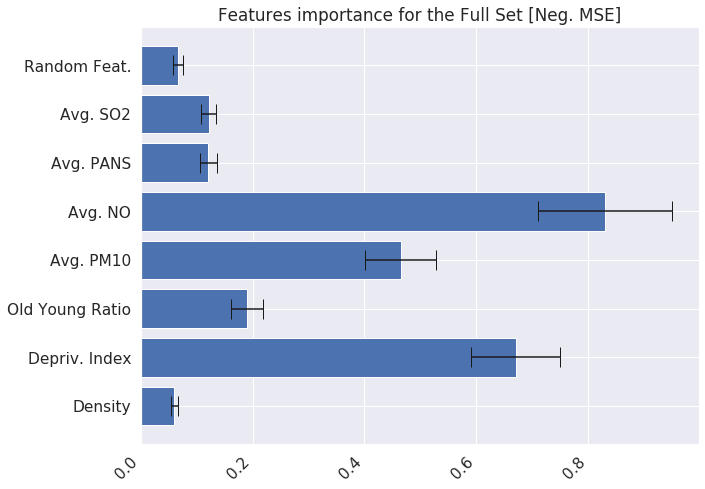

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                  Depriv. Index, Score: 0.30686 +/- 0.03637
Feature:                Old Young Ratio, Score: 0.08701 +/- 0.01324
Feature:                      Avg. PM10, Score: 0.21262 +/- 0.02888
Feature:                        Avg. NO, Score: 0.37992 +/- 0.05477
Feature:                      Avg. PANS, Score: 0.05544 +/- 0.00709
Feature:                       Avg. SO2, Score: 0.05561 +/- 0.00616


<Figure size 432x288 with 0 Axes>

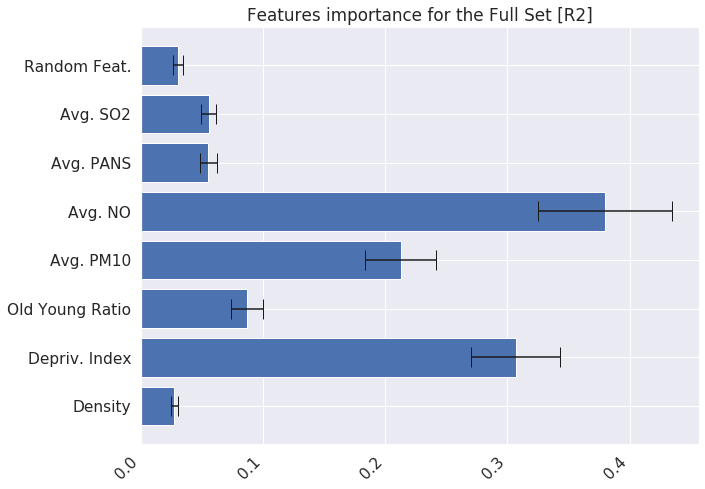

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.37060
                       R2:    0.93413


<Figure size 432x288 with 0 Axes>

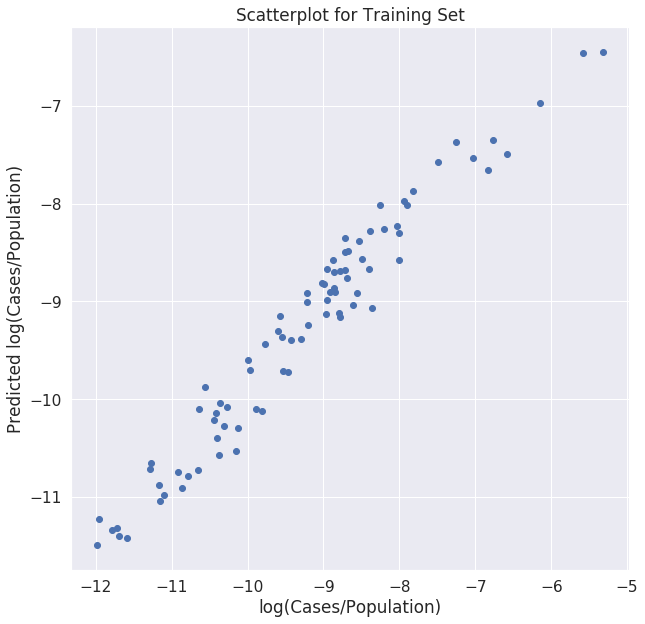

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.20361
                       R2:    0.43800


<Figure size 432x288 with 0 Axes>

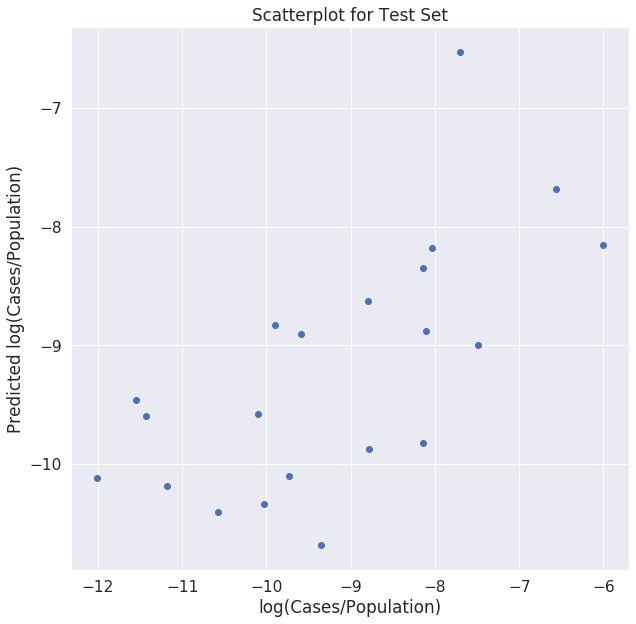

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.57683 +/- 0.21051
Feature:                Old Young Ratio, Score: 0.02543 +/- 0.10883
Feature:                      Avg. PM10, Score: 0.31288 +/- 0.21679
Feature:                        Avg. NO, Score: 0.56190 +/- 0.34612
Feature:                      Avg. PANS, Score: 0.05593 +/- 0.10827


<Figure size 432x288 with 0 Axes>

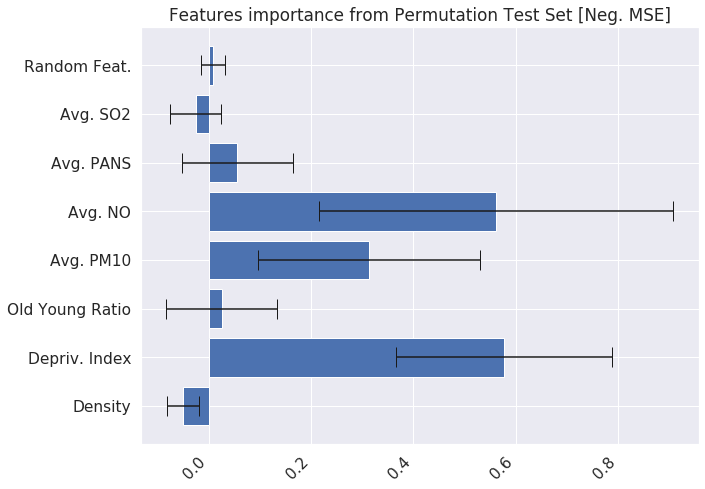

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.22377 +/- 0.08167
Feature:                Old Young Ratio, Score: 0.00987 +/- 0.04222
Feature:                      Avg. PM10, Score: 0.12138 +/- 0.08410
Feature:                        Avg. NO, Score: 0.21799 +/- 0.13428
Feature:                      Avg. PANS, Score: 0.02170 +/- 0.04200


<Figure size 432x288 with 0 Axes>

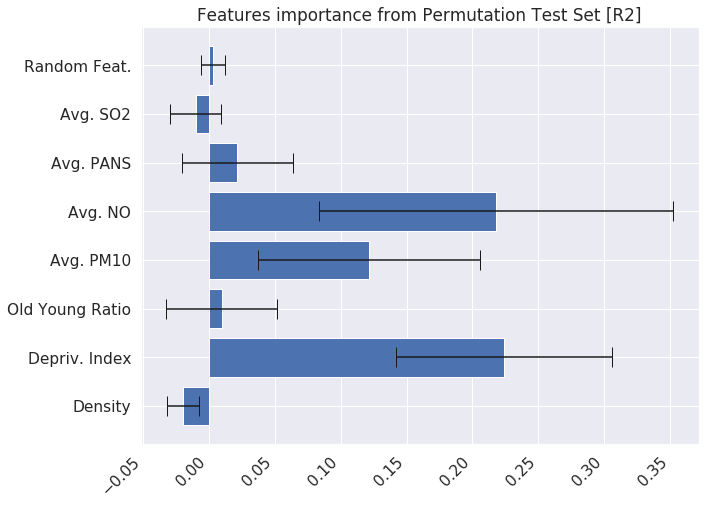

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.05172 +/- 0.00689
Feature:                  Depriv. Index, Score: 0.46023 +/- 0.08191
Feature:                Old Young Ratio, Score: 0.16060 +/- 0.02192
Feature:                      Avg. PM10, Score: 0.41790 +/- 0.05389
Feature:                        Avg. NO, Score: 0.85095 +/- 0.11514
Feature:                      Avg. PANS, Score: 0.14812 +/- 0.02351
Feature:                       Avg. SO2, Score: 0.08910 +/- 0.01098


<Figure size 432x288 with 0 Axes>

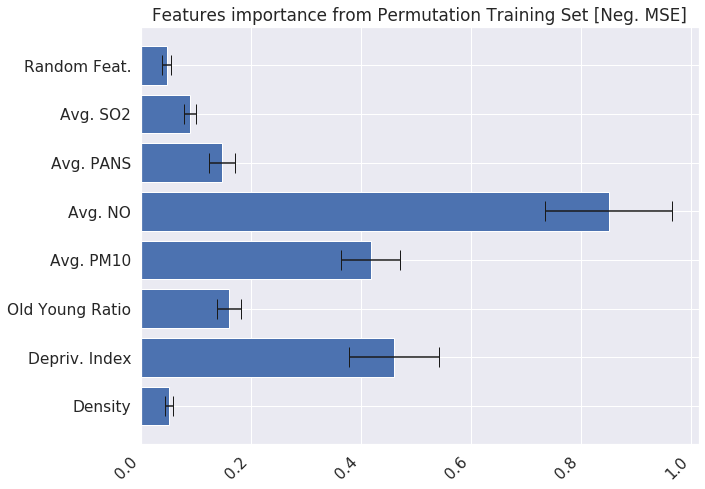

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.02480 +/- 0.00330
Feature:                  Depriv. Index, Score: 0.22072 +/- 0.03928
Feature:                Old Young Ratio, Score: 0.07702 +/- 0.01051
Feature:                      Avg. PM10, Score: 0.20043 +/- 0.02584
Feature:                        Avg. NO, Score: 0.40811 +/- 0.05522
Feature:                      Avg. PANS, Score: 0.07104 +/- 0.01127
Feature:                       Avg. SO2, Score: 0.04273 +/- 0.00527


<Figure size 432x288 with 0 Axes>

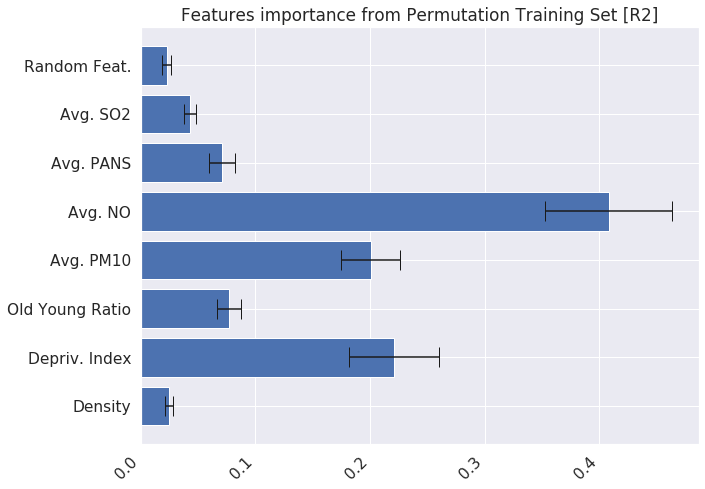

<Figure size 720x720 with 0 Axes>

In [16]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Using mutiple split test and training 

In [23]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=5, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=4)

    1 of  1200
    2 of  1200
    3 of  1200
    4 of  1200
    5 of  1200
    6 of  1200
    7 of  1200
    8 of  1200
    9 of  1200
   10 of  1200
   11 of  1200
   12 of  1200
   13 of  1200
   14 of  1200
   15 of  1200
   16 of  1200
   17 of  1200
   18 of  1200
   19 of  1200
   20 of  1200
   21 of  1200
   22 of  1200
   23 of  1200
   24 of  1200
   25 of  1200
   26 of  1200
   27 of  1200
   28 of  1200
   29 of  1200
   30 of  1200
   31 of  1200
   32 of  1200
   33 of  1200
   34 of  1200
   35 of  1200
   36 of  1200
   37 of  1200
   38 of  1200
   39 of  1200
   40 of  1200
   41 of  1200
   42 of  1200
   43 of  1200
   44 of  1200
   45 of  1200
   46 of  1200
   47 of  1200
   48 of  1200
   49 of  1200
   50 of  1200
   51 of  1200
   52 of  1200
   53 of  1200
   54 of  1200
   55 of  1200
   56 of  1200
   57 of  1200
   58 of  1200
   59 of  1200
   60 of  1200
   61 of  1200
   62 of  1200
   63 of  1200
   64 of  1200
   65 of  1200
   66 of  1200
   67 of  